In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Input, GaussianNoise
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import UpSampling2D
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import random
import cv2
import glob
import os

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    cropped_img = np.copy(img[starty:starty+cropy, startx:startx+cropx, :])
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img[p][k] = (1, 1, 1)
            else:
                img[p][k] = img[p][k]
    return (img, cropped_img)

In [34]:
def build_generator():

    model = Sequential()

    # Encoder
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(256,256,3), padding="same")) # 256 -> 128
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) # 128 -> 64
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) # 64 -> 32
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=1, strides=2, padding="same")) # 32 -> 16
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=1, strides=2, padding="same")) # 16 -> 8
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=1, strides=2, padding="same")) # 8 -> 4
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(8192))
    model.add(Reshape((4,4,512)))
    
    # Decoder
    model.add(UpSampling2D()) # 4 -> 8
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D()) # 8 -> 16
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D()) # 16 -> 32
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D()) # 32 -> 64
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D()) # 64 -> 128
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation('tanh'))


    masked_img = Input(shape=(256,256,3))
    gen_missing = model(masked_img)

    return Model(masked_img, gen_missing)

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(128,128,3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(128,128,3))
    validity = model(img)

    return Model(img, validity)

In [77]:
d_optim = Adam(lr=0.000002, beta_1=0.5, beta_2=0.999)
g_optim = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

model_discriminator = build_discriminator()
#model_discriminator.load_weights('discriminator_places')
model_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optim,
            metrics=['accuracy'])

model_generator = build_generator()
#model_generator.load_weights('generator_places')

masked_img = Input(shape=(256,256,3))
gen_missing = model_generator(masked_img)
model_discriminator.trainable = False

valid = model_discriminator(gen_missing)

model_gan = Model(masked_img , [gen_missing, valid])
model_gan.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=g_optim)

In [78]:
def get_images(batch_size, folders):
    number = str(random.randint(1, 5000))
    random_folders = random.sample(folders, batch_size)
    filename = number.zfill(8) + ".jpg"
    images = []
    for f in random_folders:
        img = cv2.imread(os.path.join(f[0],filename))
        if img is not None:
            images.append(img)
    images = np.array(images)
    X = []
    Y = []
    for i in images:
        img = crop_center(i, 128, 128)
        X.append(img[0])
        Y.append(img[1])
    X_array = np.array(X)
    Y_array = np.array(Y)
    X_array = (X_array.astype(np.float32) - 127.5)/127.5
    Y_array = (Y_array.astype(np.float32) - 127.5)/127.5
    return (X_array, Y_array)

In [79]:
folder = "Places/places2/data_256/"
folders = list(os.walk(folder))

def train(train_steps=1000000, batch_size=64):
    for i in range(train_steps):
                
        # ---------------------
        #  Get Images
        # ---------------------
        

        X, Y = get_images(batch_size, folders)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Random input
        missing_part = Y
        masked_imgs = X
        gen_missing_part = model_generator.predict(masked_imgs)
        
        # Valid and fake outputs (flipping)
        valid = np.ones([X.shape[0], 1])
        fake = np.zeros([X.shape[0], 1])

        # Train discriminator
        model_discriminator.trainable = True
        d_loss_valid = model_discriminator.train_on_batch(missing_part, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_missing_part, fake)
        d_loss = 0.5 * np.add(d_loss_valid, d_loss_fake)
        model_discriminator.trainable = False
        
        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = model_gan.train_on_batch(masked_imgs, [missing_part, valid])
        
        
        # ---------------------
        #  Logs
        # ---------------------
        if i % 100 == 0:
                model_generator.save_weights('generator_places2', True)
                model_discriminator.save_weights('discriminator_places2', True)
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

In [ ]:
train()

0 [D loss: 0.195654, acc: 95.37%] [G loss: 0.202036, mse: 0.198229]
1 [D loss: 0.167986, acc: 93.75%] [G loss: 0.204645, mse: 0.200689]
2 [D loss: 0.158634, acc: 94.79%] [G loss: 0.213142, mse: 0.210309]
3 [D loss: 0.114273, acc: 98.04%] [G loss: 0.188733, mse: 0.185697]
4 [D loss: 0.170213, acc: 97.06%] [G loss: 0.205649, mse: 0.202886]
5 [D loss: 0.259997, acc: 87.25%] [G loss: 0.181431, mse: 0.178592]
6 [D loss: 0.335825, acc: 80.85%] [G loss: 0.187126, mse: 0.184622]
7 [D loss: 0.731995, acc: 65.31%] [G loss: 0.211078, mse: 0.208835]
8 [D loss: 0.518361, acc: 71.55%] [G loss: 0.201921, mse: 0.199773]
9 [D loss: 0.128253, acc: 97.22%] [G loss: 0.220962, mse: 0.219002]
10 [D loss: 0.664532, acc: 66.67%] [G loss: 0.214933, mse: 0.212269]
11 [D loss: 0.221928, acc: 94.23%] [G loss: 0.220646, mse: 0.217309]
12 [D loss: 0.338015, acc: 85.19%] [G loss: 0.180478, mse: 0.176955]
13 [D loss: 0.128674, acc: 100.00%] [G loss: 0.208228, mse: 0.204734]
14 [D loss: 0.377664, acc: 82.08%] [G loss:

118 [D loss: 0.572662, acc: 67.24%] [G loss: 0.223959, mse: 0.220853]
119 [D loss: 0.186315, acc: 93.52%] [G loss: 0.217374, mse: 0.214782]
120 [D loss: 0.101155, acc: 98.21%] [G loss: 0.188611, mse: 0.185846]
121 [D loss: 0.284329, acc: 88.18%] [G loss: 0.223597, mse: 0.221380]
122 [D loss: 0.044198, acc: 100.00%] [G loss: 0.223633, mse: 0.220302]
123 [D loss: 0.063286, acc: 100.00%] [G loss: 0.219348, mse: 0.216353]
124 [D loss: 0.072869, acc: 98.15%] [G loss: 0.198868, mse: 0.195938]
125 [D loss: 0.077426, acc: 98.25%] [G loss: 0.208130, mse: 0.205143]
126 [D loss: 0.144401, acc: 96.00%] [G loss: 0.203358, mse: 0.200474]
127 [D loss: 0.253211, acc: 87.76%] [G loss: 0.223691, mse: 0.219869]
128 [D loss: 0.161272, acc: 95.61%] [G loss: 0.203973, mse: 0.201024]
129 [D loss: 0.124952, acc: 93.75%] [G loss: 0.225462, mse: 0.222184]
130 [D loss: 0.171622, acc: 93.52%] [G loss: 0.197985, mse: 0.195116]
131 [D loss: 0.192933, acc: 92.00%] [G loss: 0.206191, mse: 0.203404]
132 [D loss: 0.436

234 [D loss: 0.145055, acc: 94.23%] [G loss: 0.189712, mse: 0.187069]
235 [D loss: 0.145051, acc: 96.23%] [G loss: 0.206377, mse: 0.203697]
236 [D loss: 0.158253, acc: 97.27%] [G loss: 0.200373, mse: 0.197157]
237 [D loss: 0.108888, acc: 97.27%] [G loss: 0.223054, mse: 0.219397]
238 [D loss: 0.201607, acc: 92.45%] [G loss: 0.191190, mse: 0.187333]
239 [D loss: 0.527497, acc: 69.64%] [G loss: 0.210369, mse: 0.206317]
240 [D loss: 0.184722, acc: 93.86%] [G loss: 0.224040, mse: 0.221102]
241 [D loss: 0.140720, acc: 97.17%] [G loss: 0.217794, mse: 0.214165]
242 [D loss: 0.150613, acc: 96.94%] [G loss: 0.194942, mse: 0.191640]
243 [D loss: 0.132602, acc: 99.07%] [G loss: 0.213155, mse: 0.209953]
244 [D loss: 0.092289, acc: 98.15%] [G loss: 0.214757, mse: 0.211060]
245 [D loss: 1.158923, acc: 63.46%] [G loss: 0.200209, mse: 0.197348]
246 [D loss: 0.191706, acc: 92.00%] [G loss: 0.204902, mse: 0.202481]
247 [D loss: 0.100203, acc: 97.96%] [G loss: 0.218092, mse: 0.214668]
248 [D loss: 0.30698

350 [D loss: 0.191077, acc: 96.23%] [G loss: 0.201306, mse: 0.197558]
351 [D loss: 0.291267, acc: 85.45%] [G loss: 0.199593, mse: 0.196154]
352 [D loss: 0.274883, acc: 89.42%] [G loss: 0.186835, mse: 0.183508]
353 [D loss: 0.360370, acc: 79.17%] [G loss: 0.215500, mse: 0.212033]
354 [D loss: 0.187124, acc: 92.73%] [G loss: 0.221918, mse: 0.219017]
355 [D loss: 0.102314, acc: 98.98%] [G loss: 0.221483, mse: 0.218314]
356 [D loss: 0.255152, acc: 88.89%] [G loss: 0.194269, mse: 0.190741]
357 [D loss: 0.249877, acc: 87.50%] [G loss: 0.213680, mse: 0.209957]
358 [D loss: 0.276754, acc: 85.85%] [G loss: 0.187040, mse: 0.183306]
359 [D loss: 0.121091, acc: 97.37%] [G loss: 0.202505, mse: 0.198960]
360 [D loss: 0.137501, acc: 96.36%] [G loss: 0.195657, mse: 0.192029]
361 [D loss: 0.130136, acc: 95.92%] [G loss: 0.209300, mse: 0.205399]
362 [D loss: 0.113902, acc: 97.22%] [G loss: 0.192727, mse: 0.189105]
363 [D loss: 0.165227, acc: 95.00%] [G loss: 0.213935, mse: 0.209484]
364 [D loss: 0.20844

466 [D loss: 0.140190, acc: 99.02%] [G loss: 0.202695, mse: 0.197970]
467 [D loss: 0.094699, acc: 99.07%] [G loss: 0.211743, mse: 0.207288]
468 [D loss: 0.238080, acc: 90.00%] [G loss: 0.184523, mse: 0.180923]
469 [D loss: 0.376397, acc: 79.00%] [G loss: 0.188909, mse: 0.185746]
470 [D loss: 0.076210, acc: 100.00%] [G loss: 0.171667, mse: 0.169072]
471 [D loss: 0.067421, acc: 100.00%] [G loss: 0.190936, mse: 0.188898]
472 [D loss: 0.155648, acc: 94.23%] [G loss: 0.207140, mse: 0.204991]
473 [D loss: 0.104778, acc: 98.98%] [G loss: 0.211587, mse: 0.207494]
474 [D loss: 0.083188, acc: 98.94%] [G loss: 0.196782, mse: 0.192802]
475 [D loss: 0.044947, acc: 100.00%] [G loss: 0.210537, mse: 0.206796]
476 [D loss: 0.174606, acc: 95.00%] [G loss: 0.179841, mse: 0.177283]
477 [D loss: 0.072585, acc: 97.22%] [G loss: 0.192296, mse: 0.189110]
478 [D loss: 0.269228, acc: 87.00%] [G loss: 0.209066, mse: 0.206379]
479 [D loss: 0.498257, acc: 70.59%] [G loss: 0.216019, mse: 0.212739]
480 [D loss: 0.20

582 [D loss: 0.161784, acc: 94.23%] [G loss: 0.210273, mse: 0.206744]
583 [D loss: 0.116858, acc: 99.02%] [G loss: 0.206945, mse: 0.203691]
584 [D loss: 0.093603, acc: 97.27%] [G loss: 0.208390, mse: 0.205370]
585 [D loss: 0.066926, acc: 100.00%] [G loss: 0.194313, mse: 0.191102]
586 [D loss: 0.156599, acc: 93.27%] [G loss: 0.199875, mse: 0.196723]
587 [D loss: 0.453953, acc: 74.51%] [G loss: 0.190460, mse: 0.187538]
588 [D loss: 0.061380, acc: 100.00%] [G loss: 0.200709, mse: 0.197470]
589 [D loss: 0.095134, acc: 97.32%] [G loss: 0.198216, mse: 0.195739]
590 [D loss: 0.165456, acc: 94.34%] [G loss: 0.200332, mse: 0.197465]
591 [D loss: 0.362011, acc: 81.48%] [G loss: 0.208160, mse: 0.205208]
592 [D loss: 0.047573, acc: 100.00%] [G loss: 0.210309, mse: 0.206836]
593 [D loss: 0.295514, acc: 85.00%] [G loss: 0.208881, mse: 0.205824]
594 [D loss: 0.093049, acc: 99.09%] [G loss: 0.205055, mse: 0.202405]
595 [D loss: 0.164516, acc: 95.74%] [G loss: 0.181101, mse: 0.177921]
596 [D loss: 0.12

698 [D loss: 0.131446, acc: 98.04%] [G loss: 0.227098, mse: 0.223482]
699 [D loss: 0.313033, acc: 87.50%] [G loss: 0.170047, mse: 0.165777]
700 [D loss: 0.049293, acc: 100.00%] [G loss: 0.213699, mse: 0.209119]
701 [D loss: 0.103041, acc: 97.06%] [G loss: 0.195722, mse: 0.191492]
702 [D loss: 0.291638, acc: 86.11%] [G loss: 0.224203, mse: 0.221155]
703 [D loss: 0.047394, acc: 100.00%] [G loss: 0.219772, mse: 0.216361]
704 [D loss: 0.114256, acc: 95.74%] [G loss: 0.211664, mse: 0.209014]
705 [D loss: 0.111137, acc: 97.00%] [G loss: 0.234812, mse: 0.231606]
706 [D loss: 0.026267, acc: 100.00%] [G loss: 0.230140, mse: 0.226059]
707 [D loss: 0.064218, acc: 100.00%] [G loss: 0.208541, mse: 0.204763]
708 [D loss: 0.163918, acc: 97.00%] [G loss: 0.183177, mse: 0.179438]
709 [D loss: 0.106616, acc: 97.17%] [G loss: 0.220290, mse: 0.217149]
710 [D loss: 0.121419, acc: 98.94%] [G loss: 0.202628, mse: 0.199752]
711 [D loss: 0.173660, acc: 97.12%] [G loss: 0.208996, mse: 0.205706]
712 [D loss: 0.2

814 [D loss: 0.243012, acc: 91.67%] [G loss: 0.198991, mse: 0.195573]
815 [D loss: 0.171321, acc: 96.43%] [G loss: 0.195417, mse: 0.191425]
816 [D loss: 0.204195, acc: 92.39%] [G loss: 0.206317, mse: 0.203449]
817 [D loss: 0.458363, acc: 72.64%] [G loss: 0.237998, mse: 0.235225]
818 [D loss: 0.023798, acc: 100.00%] [G loss: 0.233403, mse: 0.230773]
819 [D loss: 0.189691, acc: 90.57%] [G loss: 0.221289, mse: 0.218509]
820 [D loss: 0.061609, acc: 99.09%] [G loss: 0.224982, mse: 0.222039]
821 [D loss: 0.105854, acc: 99.07%] [G loss: 0.177713, mse: 0.174477]
822 [D loss: 0.096910, acc: 97.32%] [G loss: 0.198751, mse: 0.195568]
823 [D loss: 0.121372, acc: 96.36%] [G loss: 0.209879, mse: 0.206294]
824 [D loss: 0.154488, acc: 98.15%] [G loss: 0.189332, mse: 0.186037]
825 [D loss: 0.102131, acc: 98.91%] [G loss: 0.211654, mse: 0.208463]
826 [D loss: 0.080483, acc: 100.00%] [G loss: 0.206491, mse: 0.203335]
827 [D loss: 0.107764, acc: 95.19%] [G loss: 0.204833, mse: 0.201202]
828 [D loss: 0.090

930 [D loss: 0.320530, acc: 84.44%] [G loss: 0.206607, mse: 0.203404]
931 [D loss: 0.204640, acc: 90.18%] [G loss: 0.190074, mse: 0.186599]
932 [D loss: 0.082643, acc: 98.18%] [G loss: 0.189918, mse: 0.186528]
933 [D loss: 0.106759, acc: 99.09%] [G loss: 0.214563, mse: 0.211903]
934 [D loss: 0.055611, acc: 100.00%] [G loss: 0.197087, mse: 0.193998]
935 [D loss: 0.194562, acc: 93.40%] [G loss: 0.187284, mse: 0.184573]
936 [D loss: 0.119936, acc: 97.06%] [G loss: 0.200574, mse: 0.197954]
937 [D loss: 0.036307, acc: 100.00%] [G loss: 0.214470, mse: 0.210283]
938 [D loss: 0.083600, acc: 99.06%] [G loss: 0.191646, mse: 0.187266]
939 [D loss: 0.120286, acc: 95.37%] [G loss: 0.224284, mse: 0.220505]
940 [D loss: 0.058493, acc: 100.00%] [G loss: 0.196482, mse: 0.192051]
941 [D loss: 0.034051, acc: 100.00%] [G loss: 0.219393, mse: 0.215153]
942 [D loss: 0.085731, acc: 98.08%] [G loss: 0.188184, mse: 0.184076]
943 [D loss: 0.067882, acc: 99.07%] [G loss: 0.193198, mse: 0.189994]
944 [D loss: 0.5

1046 [D loss: 0.102437, acc: 97.17%] [G loss: 0.200290, mse: 0.197158]
1047 [D loss: 0.703235, acc: 66.07%] [G loss: 0.201612, mse: 0.197588]
1048 [D loss: 0.087330, acc: 100.00%] [G loss: 0.188173, mse: 0.184412]
1049 [D loss: 0.181497, acc: 93.40%] [G loss: 0.192246, mse: 0.189157]
1050 [D loss: 0.065839, acc: 98.00%] [G loss: 0.199364, mse: 0.196392]
1051 [D loss: 0.082082, acc: 100.00%] [G loss: 0.228923, mse: 0.224788]
1052 [D loss: 0.058668, acc: 99.02%] [G loss: 0.219213, mse: 0.215188]
1053 [D loss: 0.090993, acc: 99.06%] [G loss: 0.202835, mse: 0.199862]
1054 [D loss: 0.076747, acc: 100.00%] [G loss: 0.225639, mse: 0.222335]
1055 [D loss: 0.106104, acc: 99.00%] [G loss: 0.220057, mse: 0.216632]
1056 [D loss: 0.290642, acc: 86.54%] [G loss: 0.200312, mse: 0.196286]
1057 [D loss: 0.375200, acc: 77.78%] [G loss: 0.196610, mse: 0.192708]
1058 [D loss: 0.047461, acc: 99.02%] [G loss: 0.240965, mse: 0.237422]
1059 [D loss: 0.209440, acc: 93.40%] [G loss: 0.202190, mse: 0.199370]
106

1160 [D loss: 0.091293, acc: 98.18%] [G loss: 0.214306, mse: 0.211030]
1161 [D loss: 0.073005, acc: 98.00%] [G loss: 0.221599, mse: 0.217949]
1162 [D loss: 0.075203, acc: 97.22%] [G loss: 0.217580, mse: 0.214086]
1163 [D loss: 0.106816, acc: 96.94%] [G loss: 0.208269, mse: 0.204050]
1164 [D loss: 0.145753, acc: 95.92%] [G loss: 0.207041, mse: 0.203115]
1165 [D loss: 0.109287, acc: 98.86%] [G loss: 0.205143, mse: 0.201012]
1166 [D loss: 0.040616, acc: 100.00%] [G loss: 0.206591, mse: 0.201551]
1167 [D loss: 0.115200, acc: 99.11%] [G loss: 0.212732, mse: 0.208783]
1168 [D loss: 0.060808, acc: 99.11%] [G loss: 0.216761, mse: 0.213887]
1169 [D loss: 0.044902, acc: 100.00%] [G loss: 0.232404, mse: 0.229703]
1170 [D loss: 0.252317, acc: 87.50%] [G loss: 0.202903, mse: 0.200255]
1171 [D loss: 0.069035, acc: 100.00%] [G loss: 0.204644, mse: 0.201229]
1172 [D loss: 0.192102, acc: 93.88%] [G loss: 0.202075, mse: 0.198982]
1173 [D loss: 0.103920, acc: 100.00%] [G loss: 0.199875, mse: 0.195956]
11

1274 [D loss: 0.053988, acc: 99.04%] [G loss: 0.205462, mse: 0.201294]
1275 [D loss: 0.058696, acc: 99.02%] [G loss: 0.226023, mse: 0.221530]
1276 [D loss: 0.107735, acc: 98.91%] [G loss: 0.180704, mse: 0.176831]
1277 [D loss: 0.408933, acc: 73.68%] [G loss: 0.189623, mse: 0.187362]
1278 [D loss: 0.054953, acc: 100.00%] [G loss: 0.201915, mse: 0.198081]
1279 [D loss: 0.041201, acc: 100.00%] [G loss: 0.206156, mse: 0.202867]
1280 [D loss: 0.026950, acc: 100.00%] [G loss: 0.223777, mse: 0.220020]
1281 [D loss: 0.095775, acc: 96.88%] [G loss: 0.224524, mse: 0.220987]
1282 [D loss: 0.040077, acc: 100.00%] [G loss: 0.219031, mse: 0.214423]
1283 [D loss: 0.102845, acc: 99.04%] [G loss: 0.206989, mse: 0.201863]
1284 [D loss: 0.094378, acc: 97.12%] [G loss: 0.216053, mse: 0.211031]
1285 [D loss: 0.033721, acc: 100.00%] [G loss: 0.210995, mse: 0.205402]
1286 [D loss: 0.052592, acc: 100.00%] [G loss: 0.210841, mse: 0.205821]
1287 [D loss: 0.049143, acc: 100.00%] [G loss: 0.205791, mse: 0.200936]

1388 [D loss: 0.044465, acc: 100.00%] [G loss: 0.199958, mse: 0.196170]
1389 [D loss: 0.160080, acc: 94.74%] [G loss: 0.223972, mse: 0.220451]
1390 [D loss: 0.076041, acc: 100.00%] [G loss: 0.218342, mse: 0.214760]
1391 [D loss: 0.059354, acc: 99.04%] [G loss: 0.202002, mse: 0.198219]
1392 [D loss: 0.270038, acc: 84.31%] [G loss: 0.203132, mse: 0.198930]
1393 [D loss: 0.090967, acc: 98.08%] [G loss: 0.184993, mse: 0.180237]
1394 [D loss: 0.117431, acc: 94.90%] [G loss: 0.206559, mse: 0.201880]
1395 [D loss: 0.152947, acc: 94.83%] [G loss: 0.209936, mse: 0.205672]
1396 [D loss: 0.157482, acc: 92.22%] [G loss: 0.187023, mse: 0.181861]
1397 [D loss: 0.029190, acc: 100.00%] [G loss: 0.210841, mse: 0.205951]
1398 [D loss: 0.152464, acc: 95.19%] [G loss: 0.224572, mse: 0.220646]
1399 [D loss: 0.113008, acc: 98.08%] [G loss: 0.198057, mse: 0.194148]
1400 [D loss: 0.052466, acc: 100.00%] [G loss: 0.207891, mse: 0.204754]
1401 [D loss: 0.118103, acc: 95.00%] [G loss: 0.194045, mse: 0.191025]
14

1502 [D loss: 0.042159, acc: 98.96%] [G loss: 0.236367, mse: 0.231715]
1503 [D loss: 0.073023, acc: 99.04%] [G loss: 0.198231, mse: 0.195169]
1504 [D loss: 0.192304, acc: 92.31%] [G loss: 0.216330, mse: 0.213779]
1505 [D loss: 0.146708, acc: 97.17%] [G loss: 0.206048, mse: 0.203004]
1506 [D loss: 0.189112, acc: 96.23%] [G loss: 0.211147, mse: 0.206975]
1507 [D loss: 0.534819, acc: 68.00%] [G loss: 0.219967, mse: 0.215616]
1508 [D loss: 0.197296, acc: 94.79%] [G loss: 0.188097, mse: 0.183582]
1509 [D loss: 0.066522, acc: 99.06%] [G loss: 0.193711, mse: 0.189732]
1510 [D loss: 0.115483, acc: 99.11%] [G loss: 0.198974, mse: 0.195371]
1511 [D loss: 0.042439, acc: 100.00%] [G loss: 0.218098, mse: 0.214234]
1512 [D loss: 0.095333, acc: 99.07%] [G loss: 0.173805, mse: 0.170156]
1513 [D loss: 0.121234, acc: 99.02%] [G loss: 0.212991, mse: 0.209544]
1514 [D loss: 0.117708, acc: 96.36%] [G loss: 0.195827, mse: 0.192306]
1515 [D loss: 0.026122, acc: 100.00%] [G loss: 0.221295, mse: 0.217046]
1516

1616 [D loss: 0.050625, acc: 99.02%] [G loss: 0.216559, mse: 0.212873]
1617 [D loss: 0.030325, acc: 100.00%] [G loss: 0.216331, mse: 0.211797]
1618 [D loss: 0.030299, acc: 100.00%] [G loss: 0.211110, mse: 0.206575]
1619 [D loss: 0.079076, acc: 99.09%] [G loss: 0.218579, mse: 0.214580]
1620 [D loss: 0.163126, acc: 91.35%] [G loss: 0.202267, mse: 0.197916]
1621 [D loss: 0.108354, acc: 99.11%] [G loss: 0.217813, mse: 0.213359]
1622 [D loss: 0.052701, acc: 98.98%] [G loss: 0.216214, mse: 0.212868]
1623 [D loss: 0.086832, acc: 99.06%] [G loss: 0.213422, mse: 0.209483]
1624 [D loss: 0.157051, acc: 97.27%] [G loss: 0.184271, mse: 0.180789]
1625 [D loss: 0.192593, acc: 91.51%] [G loss: 0.208800, mse: 0.204685]
1626 [D loss: 0.080046, acc: 99.09%] [G loss: 0.195886, mse: 0.192018]
1627 [D loss: 0.140792, acc: 95.10%] [G loss: 0.198563, mse: 0.194672]
1628 [D loss: 0.114263, acc: 99.07%] [G loss: 0.184562, mse: 0.180753]
1629 [D loss: 0.135667, acc: 94.55%] [G loss: 0.205176, mse: 0.200162]
1630

1730 [D loss: 0.124503, acc: 95.45%] [G loss: 0.193300, mse: 0.189612]
1731 [D loss: 0.042101, acc: 100.00%] [G loss: 0.194665, mse: 0.189916]
1732 [D loss: 0.161852, acc: 93.64%] [G loss: 0.218901, mse: 0.214340]
1733 [D loss: 0.185764, acc: 91.51%] [G loss: 0.205346, mse: 0.201430]
1734 [D loss: 0.120114, acc: 97.73%] [G loss: 0.191392, mse: 0.188177]
1735 [D loss: 0.032768, acc: 99.09%] [G loss: 0.207488, mse: 0.204053]
1736 [D loss: 0.046547, acc: 100.00%] [G loss: 0.211301, mse: 0.207321]
1737 [D loss: 0.013978, acc: 100.00%] [G loss: 0.233861, mse: 0.229739]
1738 [D loss: 0.066643, acc: 99.04%] [G loss: 0.207752, mse: 0.203767]
1739 [D loss: 0.029701, acc: 100.00%] [G loss: 0.219012, mse: 0.214501]
1740 [D loss: 0.213352, acc: 87.96%] [G loss: 0.217476, mse: 0.213485]
1741 [D loss: 0.025049, acc: 100.00%] [G loss: 0.218648, mse: 0.214164]
1742 [D loss: 0.115780, acc: 97.17%] [G loss: 0.210466, mse: 0.206452]
1743 [D loss: 0.041171, acc: 100.00%] [G loss: 0.225316, mse: 0.221294]


1844 [D loss: 0.062000, acc: 97.92%] [G loss: 0.203176, mse: 0.197965]
1845 [D loss: 0.130422, acc: 94.23%] [G loss: 0.204477, mse: 0.199323]
1846 [D loss: 0.081093, acc: 99.07%] [G loss: 0.194840, mse: 0.189042]
1847 [D loss: 0.039151, acc: 100.00%] [G loss: 0.200438, mse: 0.194772]
1848 [D loss: 0.045508, acc: 100.00%] [G loss: 0.192060, mse: 0.186766]
1849 [D loss: 0.050839, acc: 100.00%] [G loss: 0.203522, mse: 0.198940]
1850 [D loss: 0.043716, acc: 100.00%] [G loss: 0.201011, mse: 0.196990]
1851 [D loss: 0.060668, acc: 99.04%] [G loss: 0.215744, mse: 0.211981]
1852 [D loss: 0.161285, acc: 97.12%] [G loss: 0.181006, mse: 0.177728]
1853 [D loss: 0.064878, acc: 100.00%] [G loss: 0.178334, mse: 0.174522]
1854 [D loss: 0.060244, acc: 100.00%] [G loss: 0.219810, mse: 0.215858]
1855 [D loss: 0.052152, acc: 99.14%] [G loss: 0.233804, mse: 0.229057]
1856 [D loss: 0.111968, acc: 100.00%] [G loss: 0.199931, mse: 0.194550]
1857 [D loss: 0.058358, acc: 100.00%] [G loss: 0.188211, mse: 0.182326

1958 [D loss: 0.109299, acc: 98.00%] [G loss: 0.200433, mse: 0.196130]
1959 [D loss: 0.035113, acc: 100.00%] [G loss: 0.193934, mse: 0.188489]
1960 [D loss: 0.111113, acc: 96.43%] [G loss: 0.197714, mse: 0.193345]
1961 [D loss: 0.050809, acc: 99.06%] [G loss: 0.194966, mse: 0.190487]
1962 [D loss: 0.088103, acc: 98.91%] [G loss: 0.190525, mse: 0.187369]
1963 [D loss: 0.027844, acc: 100.00%] [G loss: 0.217059, mse: 0.214245]
1964 [D loss: 0.033384, acc: 100.00%] [G loss: 0.218793, mse: 0.215741]
1965 [D loss: 0.010863, acc: 100.00%] [G loss: 0.226005, mse: 0.221668]
1966 [D loss: 0.116629, acc: 98.28%] [G loss: 0.202355, mse: 0.198211]
1967 [D loss: 0.048599, acc: 100.00%] [G loss: 0.195502, mse: 0.191550]
1968 [D loss: 0.046586, acc: 100.00%] [G loss: 0.219384, mse: 0.215546]
1969 [D loss: 0.301631, acc: 78.85%] [G loss: 0.218289, mse: 0.214416]
1970 [D loss: 0.044460, acc: 100.00%] [G loss: 0.188757, mse: 0.184201]
1971 [D loss: 0.060998, acc: 100.00%] [G loss: 0.196139, mse: 0.192313

2072 [D loss: 0.033384, acc: 100.00%] [G loss: 0.218858, mse: 0.214295]
2073 [D loss: 0.025825, acc: 100.00%] [G loss: 0.208753, mse: 0.203512]
2074 [D loss: 0.191640, acc: 94.34%] [G loss: 0.196523, mse: 0.192051]
2075 [D loss: 0.327014, acc: 80.00%] [G loss: 0.208796, mse: 0.204184]
2076 [D loss: 0.065082, acc: 100.00%] [G loss: 0.193985, mse: 0.189073]
2077 [D loss: 0.053871, acc: 100.00%] [G loss: 0.211231, mse: 0.207100]
2078 [D loss: 0.051439, acc: 98.08%] [G loss: 0.214618, mse: 0.210627]
2079 [D loss: 0.045569, acc: 99.07%] [G loss: 0.223573, mse: 0.218729]
2080 [D loss: 0.031923, acc: 100.00%] [G loss: 0.200767, mse: 0.195346]
2081 [D loss: 0.057584, acc: 100.00%] [G loss: 0.230983, mse: 0.226223]
2082 [D loss: 0.022807, acc: 100.00%] [G loss: 0.235853, mse: 0.231847]
2083 [D loss: 0.031904, acc: 100.00%] [G loss: 0.226174, mse: 0.223117]
2084 [D loss: 0.176178, acc: 96.36%] [G loss: 0.205334, mse: 0.201420]
2085 [D loss: 0.033240, acc: 100.00%] [G loss: 0.222437, mse: 0.21687

2186 [D loss: 0.046491, acc: 99.09%] [G loss: 0.200971, mse: 0.195525]
2187 [D loss: 0.156573, acc: 94.12%] [G loss: 0.216554, mse: 0.211768]
2188 [D loss: 0.047723, acc: 100.00%] [G loss: 0.218128, mse: 0.212550]
2189 [D loss: 0.029180, acc: 100.00%] [G loss: 0.224646, mse: 0.219708]
2190 [D loss: 0.038330, acc: 100.00%] [G loss: 0.197739, mse: 0.191817]
2191 [D loss: 0.012038, acc: 100.00%] [G loss: 0.209587, mse: 0.204479]
2192 [D loss: 0.024041, acc: 100.00%] [G loss: 0.212830, mse: 0.206959]
2193 [D loss: 0.091940, acc: 97.22%] [G loss: 0.203976, mse: 0.198884]
2194 [D loss: 0.114991, acc: 96.23%] [G loss: 0.195444, mse: 0.191002]
2195 [D loss: 0.069512, acc: 99.14%] [G loss: 0.215810, mse: 0.210812]
2196 [D loss: 0.083837, acc: 97.92%] [G loss: 0.208265, mse: 0.204443]
2197 [D loss: 0.039838, acc: 100.00%] [G loss: 0.228005, mse: 0.223772]
2198 [D loss: 0.027009, acc: 100.00%] [G loss: 0.202158, mse: 0.197442]
2199 [D loss: 0.051906, acc: 99.00%] [G loss: 0.211460, mse: 0.207117]

2300 [D loss: 0.019809, acc: 100.00%] [G loss: 0.215402, mse: 0.209986]
2301 [D loss: 0.238994, acc: 89.81%] [G loss: 0.198927, mse: 0.193006]
2302 [D loss: 0.109838, acc: 99.07%] [G loss: 0.211186, mse: 0.204993]
2303 [D loss: 0.133401, acc: 98.04%] [G loss: 0.206747, mse: 0.201738]
2304 [D loss: 0.045557, acc: 100.00%] [G loss: 0.202396, mse: 0.197821]
2305 [D loss: 0.043538, acc: 99.11%] [G loss: 0.251163, mse: 0.246811]
2306 [D loss: 0.034094, acc: 100.00%] [G loss: 0.202569, mse: 0.197236]
2307 [D loss: 0.015584, acc: 100.00%] [G loss: 0.244720, mse: 0.239491]
2308 [D loss: 0.026596, acc: 100.00%] [G loss: 0.229570, mse: 0.225419]
2309 [D loss: 0.134279, acc: 95.00%] [G loss: 0.204518, mse: 0.199600]
2310 [D loss: 0.377608, acc: 83.02%] [G loss: 0.189391, mse: 0.184583]
2311 [D loss: 0.044497, acc: 100.00%] [G loss: 0.201855, mse: 0.197339]
2312 [D loss: 0.029400, acc: 100.00%] [G loss: 0.194839, mse: 0.191037]
2313 [D loss: 0.113146, acc: 98.08%] [G loss: 0.193626, mse: 0.190296]

2414 [D loss: 0.040411, acc: 100.00%] [G loss: 0.204451, mse: 0.198887]
2415 [D loss: 0.139364, acc: 94.12%] [G loss: 0.193077, mse: 0.187852]
2416 [D loss: 0.021883, acc: 100.00%] [G loss: 0.222352, mse: 0.216704]
2417 [D loss: 0.024077, acc: 100.00%] [G loss: 0.212370, mse: 0.207352]
2418 [D loss: 0.023758, acc: 100.00%] [G loss: 0.218072, mse: 0.213499]
2419 [D loss: 0.053841, acc: 99.09%] [G loss: 0.201268, mse: 0.196889]
2420 [D loss: 0.022293, acc: 100.00%] [G loss: 0.212948, mse: 0.208833]
2421 [D loss: 0.078763, acc: 99.02%] [G loss: 0.187943, mse: 0.183330]
2422 [D loss: 0.017253, acc: 100.00%] [G loss: 0.211190, mse: 0.207288]
2423 [D loss: 0.098129, acc: 98.15%] [G loss: 0.192220, mse: 0.189333]
2424 [D loss: 0.058122, acc: 99.12%] [G loss: 0.194751, mse: 0.191236]
2425 [D loss: 0.049132, acc: 100.00%] [G loss: 0.183280, mse: 0.179749]
2426 [D loss: 0.020806, acc: 100.00%] [G loss: 0.226366, mse: 0.222063]
2427 [D loss: 0.066569, acc: 98.89%] [G loss: 0.195667, mse: 0.190943

2528 [D loss: 0.026829, acc: 100.00%] [G loss: 0.215030, mse: 0.210719]
2529 [D loss: 0.026298, acc: 100.00%] [G loss: 0.211290, mse: 0.206951]
2530 [D loss: 0.077078, acc: 98.04%] [G loss: 0.185247, mse: 0.181254]
2531 [D loss: 0.028920, acc: 100.00%] [G loss: 0.210894, mse: 0.206590]
2532 [D loss: 0.029094, acc: 100.00%] [G loss: 0.216843, mse: 0.212451]
2533 [D loss: 0.118507, acc: 95.28%] [G loss: 0.209244, mse: 0.204967]
2534 [D loss: 0.065228, acc: 100.00%] [G loss: 0.209428, mse: 0.204927]
2535 [D loss: 0.072142, acc: 98.89%] [G loss: 0.215496, mse: 0.212375]
2536 [D loss: 0.047670, acc: 100.00%] [G loss: 0.196129, mse: 0.192325]
2537 [D loss: 0.038549, acc: 100.00%] [G loss: 0.190330, mse: 0.186560]
2538 [D loss: 0.144973, acc: 96.43%] [G loss: 0.221692, mse: 0.217623]
2539 [D loss: 0.019964, acc: 100.00%] [G loss: 0.214379, mse: 0.209449]
2540 [D loss: 0.036826, acc: 100.00%] [G loss: 0.226079, mse: 0.220943]
2541 [D loss: 0.076333, acc: 97.78%] [G loss: 0.190508, mse: 0.18549

2642 [D loss: 0.024237, acc: 100.00%] [G loss: 0.211254, mse: 0.206635]
2643 [D loss: 0.054824, acc: 97.96%] [G loss: 0.206493, mse: 0.202490]
2644 [D loss: 0.076408, acc: 100.00%] [G loss: 0.207555, mse: 0.202959]
2645 [D loss: 0.041621, acc: 100.00%] [G loss: 0.180439, mse: 0.175603]
2646 [D loss: 0.103626, acc: 97.22%] [G loss: 0.228010, mse: 0.223790]
2647 [D loss: 0.020698, acc: 100.00%] [G loss: 0.210586, mse: 0.206151]
2648 [D loss: 0.022269, acc: 100.00%] [G loss: 0.232976, mse: 0.228515]
2649 [D loss: 0.069893, acc: 100.00%] [G loss: 0.194727, mse: 0.190490]
2650 [D loss: 0.054507, acc: 100.00%] [G loss: 0.200170, mse: 0.196062]
2651 [D loss: 0.077551, acc: 98.96%] [G loss: 0.192575, mse: 0.187656]
2652 [D loss: 0.013966, acc: 100.00%] [G loss: 0.230462, mse: 0.226399]
2653 [D loss: 0.046007, acc: 100.00%] [G loss: 0.195172, mse: 0.190026]
2654 [D loss: 0.013391, acc: 100.00%] [G loss: 0.231026, mse: 0.226834]
2655 [D loss: 0.012599, acc: 100.00%] [G loss: 0.237731, mse: 0.232

2756 [D loss: 0.025083, acc: 100.00%] [G loss: 0.187249, mse: 0.181783]
2757 [D loss: 0.049272, acc: 99.12%] [G loss: 0.188679, mse: 0.183443]
2758 [D loss: 0.016096, acc: 100.00%] [G loss: 0.194275, mse: 0.189832]
2759 [D loss: 0.013301, acc: 100.00%] [G loss: 0.230012, mse: 0.225538]
2760 [D loss: 0.034879, acc: 98.98%] [G loss: 0.221836, mse: 0.217471]
2761 [D loss: 0.012145, acc: 100.00%] [G loss: 0.228475, mse: 0.223959]
2762 [D loss: 0.116026, acc: 97.12%] [G loss: 0.211685, mse: 0.206342]
2763 [D loss: 0.026864, acc: 100.00%] [G loss: 0.189814, mse: 0.185170]
2764 [D loss: 0.357285, acc: 75.00%] [G loss: 0.185417, mse: 0.181053]
2765 [D loss: 0.145797, acc: 94.55%] [G loss: 0.186442, mse: 0.182793]
2766 [D loss: 0.066856, acc: 99.09%] [G loss: 0.197809, mse: 0.193641]
2767 [D loss: 0.049683, acc: 99.06%] [G loss: 0.219115, mse: 0.215209]
2768 [D loss: 0.026898, acc: 100.00%] [G loss: 0.215489, mse: 0.210519]
2769 [D loss: 0.016515, acc: 100.00%] [G loss: 0.217368, mse: 0.211444]

2870 [D loss: 0.005349, acc: 100.00%] [G loss: 0.216293, mse: 0.211335]
2871 [D loss: 0.021353, acc: 100.00%] [G loss: 0.229947, mse: 0.225291]
2872 [D loss: 0.014203, acc: 100.00%] [G loss: 0.214855, mse: 0.209001]
2873 [D loss: 0.015587, acc: 100.00%] [G loss: 0.199004, mse: 0.193026]
2874 [D loss: 0.033331, acc: 99.04%] [G loss: 0.195067, mse: 0.189901]
2875 [D loss: 0.020534, acc: 100.00%] [G loss: 0.202866, mse: 0.197796]
2876 [D loss: 0.005497, acc: 100.00%] [G loss: 0.218352, mse: 0.213181]
2877 [D loss: 0.029754, acc: 100.00%] [G loss: 0.199066, mse: 0.194357]
2878 [D loss: 0.026158, acc: 100.00%] [G loss: 0.208143, mse: 0.204623]
2879 [D loss: 0.013612, acc: 100.00%] [G loss: 0.188327, mse: 0.183457]
2880 [D loss: 0.053258, acc: 100.00%] [G loss: 0.242329, mse: 0.238088]
2881 [D loss: 0.079538, acc: 98.96%] [G loss: 0.223873, mse: 0.219237]
2882 [D loss: 0.017881, acc: 100.00%] [G loss: 0.210945, mse: 0.206482]
2883 [D loss: 0.040795, acc: 100.00%] [G loss: 0.199105, mse: 0.19

2984 [D loss: 0.028514, acc: 100.00%] [G loss: 0.216349, mse: 0.209996]
2985 [D loss: 0.085591, acc: 98.96%] [G loss: 0.205980, mse: 0.200506]
2986 [D loss: 0.044642, acc: 100.00%] [G loss: 0.196495, mse: 0.190669]
2987 [D loss: 0.020630, acc: 99.06%] [G loss: 0.226872, mse: 0.222325]
2988 [D loss: 0.015495, acc: 100.00%] [G loss: 0.212665, mse: 0.208088]
2989 [D loss: 0.043015, acc: 100.00%] [G loss: 0.188582, mse: 0.184227]
2990 [D loss: 0.016888, acc: 100.00%] [G loss: 0.232581, mse: 0.227921]
2991 [D loss: 0.112428, acc: 95.10%] [G loss: 0.222902, mse: 0.218074]
2992 [D loss: 0.020308, acc: 100.00%] [G loss: 0.202015, mse: 0.197405]
2993 [D loss: 0.054981, acc: 100.00%] [G loss: 0.227855, mse: 0.222935]
2994 [D loss: 0.080436, acc: 98.94%] [G loss: 0.208108, mse: 0.203402]
2995 [D loss: 0.006370, acc: 100.00%] [G loss: 0.226734, mse: 0.221184]
2996 [D loss: 0.018028, acc: 100.00%] [G loss: 0.206966, mse: 0.201473]
2997 [D loss: 0.016485, acc: 100.00%] [G loss: 0.190361, mse: 0.1853

3098 [D loss: 0.049938, acc: 100.00%] [G loss: 0.210849, mse: 0.205434]
3099 [D loss: 0.015284, acc: 100.00%] [G loss: 0.217036, mse: 0.212082]
3100 [D loss: 0.016980, acc: 100.00%] [G loss: 0.183766, mse: 0.179375]
3101 [D loss: 0.021045, acc: 100.00%] [G loss: 0.202226, mse: 0.197758]
3102 [D loss: 0.011154, acc: 100.00%] [G loss: 0.192459, mse: 0.188098]
3103 [D loss: 0.052113, acc: 99.07%] [G loss: 0.223485, mse: 0.219186]
3104 [D loss: 0.040284, acc: 100.00%] [G loss: 0.186746, mse: 0.182018]
3105 [D loss: 0.023741, acc: 100.00%] [G loss: 0.206903, mse: 0.201406]
3106 [D loss: 0.040645, acc: 100.00%] [G loss: 0.207936, mse: 0.202232]
3107 [D loss: 0.039932, acc: 99.06%] [G loss: 0.235297, mse: 0.230427]
3108 [D loss: 0.115376, acc: 97.12%] [G loss: 0.219108, mse: 0.214538]
3109 [D loss: 0.053395, acc: 100.00%] [G loss: 0.209921, mse: 0.205203]
3110 [D loss: 0.043579, acc: 100.00%] [G loss: 0.230831, mse: 0.225841]
3111 [D loss: 0.019994, acc: 100.00%] [G loss: 0.200498, mse: 0.195

3212 [D loss: 0.005569, acc: 100.00%] [G loss: 0.214008, mse: 0.208628]
3213 [D loss: 0.014190, acc: 100.00%] [G loss: 0.218918, mse: 0.214526]
3214 [D loss: 0.022395, acc: 100.00%] [G loss: 0.199910, mse: 0.195026]
3215 [D loss: 0.011146, acc: 100.00%] [G loss: 0.205427, mse: 0.201377]
3216 [D loss: 0.013217, acc: 100.00%] [G loss: 0.200152, mse: 0.196371]
3217 [D loss: 0.021094, acc: 100.00%] [G loss: 0.207726, mse: 0.203741]
3218 [D loss: 0.022472, acc: 100.00%] [G loss: 0.211982, mse: 0.207112]
3219 [D loss: 0.027506, acc: 100.00%] [G loss: 0.200074, mse: 0.194549]
3220 [D loss: 0.015167, acc: 100.00%] [G loss: 0.216137, mse: 0.210038]
3221 [D loss: 0.012438, acc: 100.00%] [G loss: 0.202262, mse: 0.197112]
3222 [D loss: 0.025220, acc: 100.00%] [G loss: 0.192948, mse: 0.187939]
3223 [D loss: 0.018995, acc: 100.00%] [G loss: 0.218016, mse: 0.213358]
3224 [D loss: 0.017454, acc: 100.00%] [G loss: 0.213352, mse: 0.208094]
3225 [D loss: 0.008847, acc: 100.00%] [G loss: 0.224071, mse: 0.

3326 [D loss: 0.028283, acc: 100.00%] [G loss: 0.209257, mse: 0.203369]
3327 [D loss: 0.021037, acc: 100.00%] [G loss: 0.203103, mse: 0.196697]
3328 [D loss: 0.013267, acc: 100.00%] [G loss: 0.207058, mse: 0.200551]
3329 [D loss: 0.013415, acc: 100.00%] [G loss: 0.198438, mse: 0.192800]
3330 [D loss: 0.025848, acc: 100.00%] [G loss: 0.198844, mse: 0.193556]
3331 [D loss: 0.033999, acc: 100.00%] [G loss: 0.172863, mse: 0.168178]
3332 [D loss: 0.135827, acc: 94.00%] [G loss: 0.188481, mse: 0.184053]
3333 [D loss: 0.040699, acc: 100.00%] [G loss: 0.172310, mse: 0.168126]
3334 [D loss: 0.028557, acc: 98.98%] [G loss: 0.208504, mse: 0.204043]
3335 [D loss: 0.023956, acc: 100.00%] [G loss: 0.185493, mse: 0.180793]
3336 [D loss: 0.016300, acc: 100.00%] [G loss: 0.213163, mse: 0.208296]
3337 [D loss: 0.021662, acc: 100.00%] [G loss: 0.216871, mse: 0.211161]
3338 [D loss: 0.029268, acc: 100.00%] [G loss: 0.198195, mse: 0.192019]
3339 [D loss: 0.014495, acc: 100.00%] [G loss: 0.225170, mse: 0.21

3440 [D loss: 0.046074, acc: 100.00%] [G loss: 0.212097, mse: 0.207418]
3441 [D loss: 0.012316, acc: 100.00%] [G loss: 0.212226, mse: 0.206339]
3442 [D loss: 0.031469, acc: 100.00%] [G loss: 0.204545, mse: 0.199653]
3443 [D loss: 0.072914, acc: 98.91%] [G loss: 0.199906, mse: 0.195345]
3444 [D loss: 0.140387, acc: 94.74%] [G loss: 0.197882, mse: 0.193520]
3445 [D loss: 0.015233, acc: 100.00%] [G loss: 0.235658, mse: 0.231664]
3446 [D loss: 0.014237, acc: 100.00%] [G loss: 0.207241, mse: 0.201684]
3447 [D loss: 0.009144, acc: 100.00%] [G loss: 0.238275, mse: 0.232275]
3448 [D loss: 0.010388, acc: 100.00%] [G loss: 0.230813, mse: 0.224382]
3449 [D loss: 0.029280, acc: 100.00%] [G loss: 0.199566, mse: 0.193158]
3450 [D loss: 0.176207, acc: 92.98%] [G loss: 0.195392, mse: 0.189575]
3451 [D loss: 0.016993, acc: 100.00%] [G loss: 0.233003, mse: 0.227735]
3452 [D loss: 0.038721, acc: 100.00%] [G loss: 0.193125, mse: 0.187604]
3453 [D loss: 0.144642, acc: 96.15%] [G loss: 0.211546, mse: 0.2059

3554 [D loss: 0.015739, acc: 100.00%] [G loss: 0.199373, mse: 0.194090]
3555 [D loss: 0.037268, acc: 100.00%] [G loss: 0.190056, mse: 0.184590]
3556 [D loss: 0.063682, acc: 100.00%] [G loss: 0.209012, mse: 0.203876]
3557 [D loss: 0.019125, acc: 100.00%] [G loss: 0.221634, mse: 0.215907]
3558 [D loss: 0.026387, acc: 100.00%] [G loss: 0.219062, mse: 0.214096]
3559 [D loss: 0.008329, acc: 100.00%] [G loss: 0.223411, mse: 0.217210]
3560 [D loss: 0.009482, acc: 100.00%] [G loss: 0.211087, mse: 0.205176]
3561 [D loss: 0.089857, acc: 96.23%] [G loss: 0.187604, mse: 0.182241]
3562 [D loss: 0.027676, acc: 100.00%] [G loss: 0.199890, mse: 0.194310]
3563 [D loss: 0.025614, acc: 100.00%] [G loss: 0.219938, mse: 0.213759]
3564 [D loss: 0.029178, acc: 100.00%] [G loss: 0.203537, mse: 0.197780]
3565 [D loss: 0.006027, acc: 100.00%] [G loss: 0.233726, mse: 0.228120]
3566 [D loss: 0.004203, acc: 100.00%] [G loss: 0.229775, mse: 0.223607]
3567 [D loss: 0.007883, acc: 100.00%] [G loss: 0.207767, mse: 0.2

3668 [D loss: 0.016804, acc: 100.00%] [G loss: 0.219066, mse: 0.213433]
3669 [D loss: 0.021327, acc: 100.00%] [G loss: 0.199896, mse: 0.194340]
3670 [D loss: 0.023549, acc: 100.00%] [G loss: 0.212832, mse: 0.207594]
3671 [D loss: 0.007337, acc: 100.00%] [G loss: 0.215609, mse: 0.210867]
3672 [D loss: 0.008679, acc: 100.00%] [G loss: 0.210754, mse: 0.206069]
3673 [D loss: 0.011466, acc: 100.00%] [G loss: 0.192133, mse: 0.187894]
3674 [D loss: 0.011819, acc: 100.00%] [G loss: 0.210955, mse: 0.206416]
3675 [D loss: 0.027661, acc: 100.00%] [G loss: 0.190984, mse: 0.186175]
3676 [D loss: 0.073528, acc: 98.18%] [G loss: 0.179318, mse: 0.174976]
3677 [D loss: 0.104512, acc: 95.28%] [G loss: 0.206394, mse: 0.201863]
3678 [D loss: 0.025241, acc: 100.00%] [G loss: 0.203573, mse: 0.199007]
3679 [D loss: 0.024248, acc: 100.00%] [G loss: 0.218712, mse: 0.213973]
3680 [D loss: 0.007876, acc: 100.00%] [G loss: 0.215751, mse: 0.210001]
3681 [D loss: 0.038400, acc: 100.00%] [G loss: 0.194912, mse: 0.18

3782 [D loss: 0.014928, acc: 100.00%] [G loss: 0.213721, mse: 0.208411]
3783 [D loss: 0.036887, acc: 100.00%] [G loss: 0.218663, mse: 0.214122]
3784 [D loss: 0.021619, acc: 100.00%] [G loss: 0.201002, mse: 0.195042]
3785 [D loss: 0.006643, acc: 100.00%] [G loss: 0.211964, mse: 0.206665]
3786 [D loss: 0.008371, acc: 100.00%] [G loss: 0.211819, mse: 0.207209]
3787 [D loss: 0.067543, acc: 98.00%] [G loss: 0.188654, mse: 0.183876]
3788 [D loss: 0.005837, acc: 100.00%] [G loss: 0.204318, mse: 0.198844]
3789 [D loss: 0.007470, acc: 100.00%] [G loss: 0.225572, mse: 0.220262]
3790 [D loss: 0.036551, acc: 99.02%] [G loss: 0.219991, mse: 0.214931]
3791 [D loss: 0.021346, acc: 100.00%] [G loss: 0.197153, mse: 0.191251]
3792 [D loss: 0.194685, acc: 91.49%] [G loss: 0.246924, mse: 0.240810]
3793 [D loss: 0.026662, acc: 100.00%] [G loss: 0.220401, mse: 0.214876]
3794 [D loss: 0.019618, acc: 100.00%] [G loss: 0.198484, mse: 0.193805]
3795 [D loss: 0.016110, acc: 100.00%] [G loss: 0.208457, mse: 0.203

3896 [D loss: 0.029957, acc: 100.00%] [G loss: 0.187490, mse: 0.182474]
3897 [D loss: 0.019018, acc: 100.00%] [G loss: 0.212634, mse: 0.207548]
3898 [D loss: 0.008285, acc: 100.00%] [G loss: 0.213654, mse: 0.207836]
3899 [D loss: 0.022736, acc: 100.00%] [G loss: 0.208139, mse: 0.201921]
3900 [D loss: 0.033508, acc: 100.00%] [G loss: 0.211023, mse: 0.204351]
3901 [D loss: 0.010865, acc: 100.00%] [G loss: 0.204489, mse: 0.198429]
3902 [D loss: 0.007181, acc: 100.00%] [G loss: 0.223827, mse: 0.219311]
3903 [D loss: 0.005462, acc: 100.00%] [G loss: 0.206548, mse: 0.200724]
3904 [D loss: 0.004459, acc: 100.00%] [G loss: 0.218746, mse: 0.213380]
3905 [D loss: 0.014651, acc: 100.00%] [G loss: 0.219462, mse: 0.214242]
3906 [D loss: 0.006816, acc: 100.00%] [G loss: 0.223226, mse: 0.217856]
3907 [D loss: 0.021403, acc: 100.00%] [G loss: 0.214760, mse: 0.209207]
3908 [D loss: 0.015590, acc: 100.00%] [G loss: 0.215424, mse: 0.209317]
3909 [D loss: 0.045864, acc: 100.00%] [G loss: 0.210037, mse: 0.

4010 [D loss: 0.011674, acc: 100.00%] [G loss: 0.224131, mse: 0.218750]
4011 [D loss: 0.014179, acc: 100.00%] [G loss: 0.201047, mse: 0.195423]
4012 [D loss: 0.011553, acc: 100.00%] [G loss: 0.216234, mse: 0.210765]
4013 [D loss: 0.009349, acc: 100.00%] [G loss: 0.210538, mse: 0.205539]
4014 [D loss: 0.034635, acc: 100.00%] [G loss: 0.210572, mse: 0.205744]
4015 [D loss: 0.015168, acc: 100.00%] [G loss: 0.223866, mse: 0.219097]
4016 [D loss: 0.018497, acc: 100.00%] [G loss: 0.205614, mse: 0.200339]
4017 [D loss: 0.009768, acc: 100.00%] [G loss: 0.226215, mse: 0.221388]
4018 [D loss: 0.019650, acc: 100.00%] [G loss: 0.235920, mse: 0.231502]
4019 [D loss: 0.033806, acc: 100.00%] [G loss: 0.199390, mse: 0.194433]
4020 [D loss: 0.035378, acc: 100.00%] [G loss: 0.183855, mse: 0.179529]
4021 [D loss: 0.007492, acc: 100.00%] [G loss: 0.221253, mse: 0.217276]
4022 [D loss: 0.013612, acc: 100.00%] [G loss: 0.205322, mse: 0.201353]
4023 [D loss: 0.042389, acc: 100.00%] [G loss: 0.187596, mse: 0.

4123 [D loss: 0.026079, acc: 100.00%] [G loss: 0.215540, mse: 0.209936]
4124 [D loss: 0.134572, acc: 96.30%] [G loss: 0.207483, mse: 0.201771]
4125 [D loss: 0.010651, acc: 100.00%] [G loss: 0.234205, mse: 0.228552]
4126 [D loss: 0.033803, acc: 100.00%] [G loss: 0.199262, mse: 0.193086]
4127 [D loss: 0.027636, acc: 100.00%] [G loss: 0.207866, mse: 0.201641]
4128 [D loss: 0.053224, acc: 98.00%] [G loss: 0.186809, mse: 0.179975]
4129 [D loss: 0.007747, acc: 100.00%] [G loss: 0.233676, mse: 0.227153]
4130 [D loss: 0.019907, acc: 100.00%] [G loss: 0.212122, mse: 0.206036]
4131 [D loss: 0.008368, acc: 100.00%] [G loss: 0.215545, mse: 0.209337]
4132 [D loss: 0.009882, acc: 100.00%] [G loss: 0.216265, mse: 0.211081]
4133 [D loss: 0.009598, acc: 100.00%] [G loss: 0.197423, mse: 0.192551]
4134 [D loss: 0.007471, acc: 100.00%] [G loss: 0.226293, mse: 0.221299]
4135 [D loss: 0.024091, acc: 100.00%] [G loss: 0.224069, mse: 0.219543]
4136 [D loss: 0.007388, acc: 100.00%] [G loss: 0.216827, mse: 0.21

4237 [D loss: 0.049924, acc: 98.15%] [G loss: 0.227448, mse: 0.220729]
4238 [D loss: 0.025736, acc: 100.00%] [G loss: 0.210462, mse: 0.204042]
4239 [D loss: 0.009069, acc: 100.00%] [G loss: 0.210700, mse: 0.203991]
4240 [D loss: 0.028322, acc: 100.00%] [G loss: 0.190322, mse: 0.184547]
4241 [D loss: 0.018221, acc: 100.00%] [G loss: 0.238834, mse: 0.233103]
4242 [D loss: 0.055408, acc: 100.00%] [G loss: 0.215713, mse: 0.210228]
4243 [D loss: 0.009993, acc: 100.00%] [G loss: 0.212908, mse: 0.206873]
4244 [D loss: 0.006805, acc: 100.00%] [G loss: 0.209536, mse: 0.203762]
4245 [D loss: 0.013422, acc: 100.00%] [G loss: 0.195984, mse: 0.190423]
4246 [D loss: 0.046230, acc: 99.04%] [G loss: 0.212231, mse: 0.206639]
4247 [D loss: 0.018717, acc: 100.00%] [G loss: 0.207091, mse: 0.200055]
4248 [D loss: 0.070995, acc: 96.94%] [G loss: 0.190180, mse: 0.183401]
4249 [D loss: 0.009781, acc: 100.00%] [G loss: 0.206865, mse: 0.199594]
4250 [D loss: 0.020648, acc: 100.00%] [G loss: 0.203428, mse: 0.198

4351 [D loss: 0.006678, acc: 100.00%] [G loss: 0.219433, mse: 0.213621]
4352 [D loss: 0.015534, acc: 100.00%] [G loss: 0.203766, mse: 0.197420]
4353 [D loss: 0.007555, acc: 100.00%] [G loss: 0.203983, mse: 0.197833]
4354 [D loss: 0.021516, acc: 100.00%] [G loss: 0.214669, mse: 0.208920]
4355 [D loss: 0.018889, acc: 100.00%] [G loss: 0.194291, mse: 0.187882]
4356 [D loss: 0.014051, acc: 100.00%] [G loss: 0.199755, mse: 0.193131]
4357 [D loss: 0.012588, acc: 100.00%] [G loss: 0.209337, mse: 0.202905]
4358 [D loss: 0.042447, acc: 100.00%] [G loss: 0.208446, mse: 0.202490]
4359 [D loss: 0.013427, acc: 100.00%] [G loss: 0.194080, mse: 0.187797]
4360 [D loss: 0.010245, acc: 100.00%] [G loss: 0.190834, mse: 0.184267]
4361 [D loss: 0.004842, acc: 100.00%] [G loss: 0.220787, mse: 0.214951]
4362 [D loss: 0.034914, acc: 100.00%] [G loss: 0.200862, mse: 0.194053]
4363 [D loss: 0.018043, acc: 100.00%] [G loss: 0.196087, mse: 0.189594]
4364 [D loss: 0.013834, acc: 100.00%] [G loss: 0.224127, mse: 0.

4465 [D loss: 0.032571, acc: 100.00%] [G loss: 0.203870, mse: 0.197762]
4466 [D loss: 0.015655, acc: 100.00%] [G loss: 0.220826, mse: 0.214087]
4467 [D loss: 0.005967, acc: 100.00%] [G loss: 0.211298, mse: 0.204463]
4468 [D loss: 0.003270, acc: 100.00%] [G loss: 0.236126, mse: 0.229452]
4469 [D loss: 0.006538, acc: 100.00%] [G loss: 0.218733, mse: 0.212798]
4470 [D loss: 0.012125, acc: 100.00%] [G loss: 0.213144, mse: 0.207836]
4471 [D loss: 0.050436, acc: 99.06%] [G loss: 0.198205, mse: 0.193680]
4472 [D loss: 0.053076, acc: 99.12%] [G loss: 0.213800, mse: 0.209136]
4473 [D loss: 0.028645, acc: 100.00%] [G loss: 0.208914, mse: 0.203834]
4474 [D loss: 0.022078, acc: 100.00%] [G loss: 0.203767, mse: 0.198937]
4475 [D loss: 0.037230, acc: 100.00%] [G loss: 0.223523, mse: 0.218341]
4476 [D loss: 0.008323, acc: 100.00%] [G loss: 0.224206, mse: 0.219490]
4477 [D loss: 0.015547, acc: 100.00%] [G loss: 0.214094, mse: 0.208375]
4478 [D loss: 0.043453, acc: 100.00%] [G loss: 0.201623, mse: 0.19

4578 [D loss: 0.006080, acc: 100.00%] [G loss: 0.206510, mse: 0.201231]
4579 [D loss: 0.032872, acc: 99.07%] [G loss: 0.214302, mse: 0.209636]
4580 [D loss: 0.006973, acc: 100.00%] [G loss: 0.210482, mse: 0.204846]
4581 [D loss: 0.014827, acc: 100.00%] [G loss: 0.187776, mse: 0.182411]
4582 [D loss: 0.006328, acc: 100.00%] [G loss: 0.237678, mse: 0.231844]
4583 [D loss: 0.032744, acc: 98.18%] [G loss: 0.209085, mse: 0.204651]
4584 [D loss: 0.004992, acc: 100.00%] [G loss: 0.222727, mse: 0.217555]
4585 [D loss: 0.014482, acc: 100.00%] [G loss: 0.218223, mse: 0.213510]
4586 [D loss: 0.013913, acc: 100.00%] [G loss: 0.209203, mse: 0.203660]
4587 [D loss: 0.016770, acc: 100.00%] [G loss: 0.195195, mse: 0.189447]
4588 [D loss: 0.013426, acc: 100.00%] [G loss: 0.211380, mse: 0.205826]
4589 [D loss: 0.006585, acc: 100.00%] [G loss: 0.223926, mse: 0.218663]
4590 [D loss: 0.005404, acc: 100.00%] [G loss: 0.218812, mse: 0.213501]
4591 [D loss: 0.029316, acc: 100.00%] [G loss: 0.213811, mse: 0.20

4691 [D loss: 0.031923, acc: 100.00%] [G loss: 0.193969, mse: 0.188750]
4692 [D loss: 0.022061, acc: 100.00%] [G loss: 0.202243, mse: 0.196669]
4693 [D loss: 0.006271, acc: 100.00%] [G loss: 0.218871, mse: 0.213792]
4694 [D loss: 0.006843, acc: 100.00%] [G loss: 0.212441, mse: 0.207084]
4695 [D loss: 0.005140, acc: 100.00%] [G loss: 0.224782, mse: 0.218316]
4696 [D loss: 0.016203, acc: 100.00%] [G loss: 0.199861, mse: 0.193766]
4697 [D loss: 0.010385, acc: 100.00%] [G loss: 0.202305, mse: 0.196055]
4698 [D loss: 0.016819, acc: 100.00%] [G loss: 0.202444, mse: 0.197268]
4699 [D loss: 0.059711, acc: 98.11%] [G loss: 0.206547, mse: 0.201010]
4700 [D loss: 0.042009, acc: 100.00%] [G loss: 0.213357, mse: 0.209021]
4701 [D loss: 0.034314, acc: 100.00%] [G loss: 0.209429, mse: 0.205415]
4702 [D loss: 0.048977, acc: 100.00%] [G loss: 0.203097, mse: 0.198698]
4703 [D loss: 0.015114, acc: 100.00%] [G loss: 0.226298, mse: 0.220814]
4704 [D loss: 0.009858, acc: 100.00%] [G loss: 0.216625, mse: 0.2

4805 [D loss: 0.015309, acc: 100.00%] [G loss: 0.213671, mse: 0.207924]
4806 [D loss: 0.016961, acc: 100.00%] [G loss: 0.213782, mse: 0.207785]
4807 [D loss: 0.004029, acc: 100.00%] [G loss: 0.218402, mse: 0.212189]
4808 [D loss: 0.003686, acc: 100.00%] [G loss: 0.190595, mse: 0.184102]
4809 [D loss: 0.042049, acc: 100.00%] [G loss: 0.215631, mse: 0.210649]
4810 [D loss: 0.006564, acc: 100.00%] [G loss: 0.236087, mse: 0.230846]
4811 [D loss: 0.017182, acc: 100.00%] [G loss: 0.238632, mse: 0.233454]
4812 [D loss: 0.014477, acc: 100.00%] [G loss: 0.205083, mse: 0.200096]
4813 [D loss: 0.003030, acc: 100.00%] [G loss: 0.202658, mse: 0.196087]
4814 [D loss: 0.004193, acc: 100.00%] [G loss: 0.203110, mse: 0.197801]
4815 [D loss: 0.002895, acc: 100.00%] [G loss: 0.217869, mse: 0.212981]
4816 [D loss: 0.019248, acc: 100.00%] [G loss: 0.202468, mse: 0.197273]
4817 [D loss: 0.008890, acc: 100.00%] [G loss: 0.213892, mse: 0.209237]
4818 [D loss: 0.009039, acc: 100.00%] [G loss: 0.222164, mse: 0.

4918 [D loss: 0.079582, acc: 97.27%] [G loss: 0.180469, mse: 0.175038]
4919 [D loss: 0.026326, acc: 100.00%] [G loss: 0.199356, mse: 0.193807]
4920 [D loss: 0.022862, acc: 100.00%] [G loss: 0.178171, mse: 0.172324]
4921 [D loss: 0.001608, acc: 100.00%] [G loss: 0.224877, mse: 0.219515]
4922 [D loss: 0.008352, acc: 100.00%] [G loss: 0.208118, mse: 0.203241]
4923 [D loss: 0.083793, acc: 98.15%] [G loss: 0.228133, mse: 0.223022]
4924 [D loss: 0.006605, acc: 100.00%] [G loss: 0.217953, mse: 0.212885]
4925 [D loss: 0.004362, acc: 100.00%] [G loss: 0.245122, mse: 0.239811]
4926 [D loss: 0.012121, acc: 100.00%] [G loss: 0.212696, mse: 0.206669]
4927 [D loss: 0.024388, acc: 98.98%] [G loss: 0.249381, mse: 0.242656]
4928 [D loss: 0.006688, acc: 100.00%] [G loss: 0.235031, mse: 0.227548]
4929 [D loss: 0.006117, acc: 100.00%] [G loss: 0.218986, mse: 0.212512]
4930 [D loss: 0.014617, acc: 100.00%] [G loss: 0.210529, mse: 0.204424]
4931 [D loss: 0.003555, acc: 100.00%] [G loss: 0.216323, mse: 0.209

5031 [D loss: 0.005246, acc: 100.00%] [G loss: 0.188960, mse: 0.182915]
5032 [D loss: 0.006074, acc: 100.00%] [G loss: 0.188963, mse: 0.183179]
5033 [D loss: 0.048830, acc: 100.00%] [G loss: 0.189700, mse: 0.184969]
5034 [D loss: 0.023041, acc: 100.00%] [G loss: 0.178972, mse: 0.173990]
5035 [D loss: 0.009443, acc: 100.00%] [G loss: 0.212690, mse: 0.206711]
5036 [D loss: 0.021097, acc: 100.00%] [G loss: 0.191414, mse: 0.185139]
5037 [D loss: 0.015619, acc: 100.00%] [G loss: 0.201910, mse: 0.196098]
5038 [D loss: 0.008027, acc: 100.00%] [G loss: 0.211812, mse: 0.205885]
5039 [D loss: 0.010100, acc: 100.00%] [G loss: 0.208266, mse: 0.201900]
5040 [D loss: 0.011884, acc: 100.00%] [G loss: 0.193154, mse: 0.186526]
5041 [D loss: 0.007239, acc: 100.00%] [G loss: 0.241364, mse: 0.235897]
5042 [D loss: 0.012631, acc: 100.00%] [G loss: 0.206509, mse: 0.200073]
5043 [D loss: 0.005346, acc: 100.00%] [G loss: 0.227317, mse: 0.220515]
5044 [D loss: 0.006601, acc: 100.00%] [G loss: 0.222600, mse: 0.

5144 [D loss: 0.015345, acc: 100.00%] [G loss: 0.196732, mse: 0.191088]
5145 [D loss: 0.016401, acc: 100.00%] [G loss: 0.202734, mse: 0.197105]
5146 [D loss: 0.010727, acc: 100.00%] [G loss: 0.220617, mse: 0.214325]
5147 [D loss: 0.011095, acc: 100.00%] [G loss: 0.213291, mse: 0.206760]
5148 [D loss: 0.009652, acc: 100.00%] [G loss: 0.226318, mse: 0.218761]
5149 [D loss: 0.030380, acc: 100.00%] [G loss: 0.214093, mse: 0.207481]
5150 [D loss: 0.033276, acc: 100.00%] [G loss: 0.201765, mse: 0.196034]
5151 [D loss: 0.001559, acc: 100.00%] [G loss: 0.220616, mse: 0.215074]
5152 [D loss: 0.020105, acc: 99.11%] [G loss: 0.197621, mse: 0.191956]
5153 [D loss: 0.029797, acc: 100.00%] [G loss: 0.197430, mse: 0.192070]
5154 [D loss: 0.038759, acc: 99.00%] [G loss: 0.221333, mse: 0.214815]
5155 [D loss: 0.021686, acc: 100.00%] [G loss: 0.195105, mse: 0.188485]
5156 [D loss: 0.011932, acc: 100.00%] [G loss: 0.201926, mse: 0.195771]
5157 [D loss: 0.019420, acc: 100.00%] [G loss: 0.222285, mse: 0.21

5257 [D loss: 0.018038, acc: 100.00%] [G loss: 0.217679, mse: 0.211234]
5258 [D loss: 0.009167, acc: 100.00%] [G loss: 0.218483, mse: 0.212082]
5259 [D loss: 0.005306, acc: 100.00%] [G loss: 0.213687, mse: 0.207515]
5260 [D loss: 0.004467, acc: 100.00%] [G loss: 0.211398, mse: 0.204947]
5261 [D loss: 0.016675, acc: 100.00%] [G loss: 0.225056, mse: 0.219574]
5262 [D loss: 0.018499, acc: 100.00%] [G loss: 0.204235, mse: 0.198584]
5263 [D loss: 0.010659, acc: 100.00%] [G loss: 0.204692, mse: 0.198319]
5264 [D loss: 0.005012, acc: 100.00%] [G loss: 0.200764, mse: 0.194118]
5265 [D loss: 0.008738, acc: 100.00%] [G loss: 0.215489, mse: 0.209541]
5266 [D loss: 0.013879, acc: 100.00%] [G loss: 0.208324, mse: 0.202503]
5267 [D loss: 0.007059, acc: 100.00%] [G loss: 0.197390, mse: 0.191590]
5268 [D loss: 0.008725, acc: 100.00%] [G loss: 0.214149, mse: 0.208226]
5269 [D loss: 0.006487, acc: 100.00%] [G loss: 0.208530, mse: 0.202827]
5270 [D loss: 0.007296, acc: 100.00%] [G loss: 0.205396, mse: 0.

5370 [D loss: 0.001450, acc: 100.00%] [G loss: 0.225166, mse: 0.218805]
5371 [D loss: 0.012798, acc: 100.00%] [G loss: 0.199899, mse: 0.194469]
5372 [D loss: 0.001591, acc: 100.00%] [G loss: 0.236935, mse: 0.231064]
5373 [D loss: 0.000963, acc: 100.00%] [G loss: 0.224821, mse: 0.218706]
5374 [D loss: 0.003035, acc: 100.00%] [G loss: 0.232661, mse: 0.225943]
5375 [D loss: 0.007838, acc: 100.00%] [G loss: 0.203338, mse: 0.197052]
5376 [D loss: 0.002979, acc: 100.00%] [G loss: 0.215863, mse: 0.209266]
5377 [D loss: 0.005143, acc: 100.00%] [G loss: 0.204966, mse: 0.198220]
5378 [D loss: 0.011410, acc: 100.00%] [G loss: 0.196753, mse: 0.190555]
5379 [D loss: 0.010773, acc: 100.00%] [G loss: 0.214036, mse: 0.207712]
5380 [D loss: 0.035103, acc: 100.00%] [G loss: 0.213585, mse: 0.207321]
5381 [D loss: 0.006669, acc: 100.00%] [G loss: 0.221232, mse: 0.215166]
5382 [D loss: 0.015666, acc: 100.00%] [G loss: 0.205628, mse: 0.199460]
5383 [D loss: 0.014844, acc: 100.00%] [G loss: 0.207275, mse: 0.

5483 [D loss: 0.009914, acc: 100.00%] [G loss: 0.191195, mse: 0.184997]
5484 [D loss: 0.004373, acc: 100.00%] [G loss: 0.206584, mse: 0.200515]
5485 [D loss: 0.007607, acc: 100.00%] [G loss: 0.217391, mse: 0.212126]
5486 [D loss: 0.008861, acc: 100.00%] [G loss: 0.197918, mse: 0.192508]
5487 [D loss: 0.005773, acc: 100.00%] [G loss: 0.216330, mse: 0.210901]
5488 [D loss: 0.003939, acc: 100.00%] [G loss: 0.227773, mse: 0.221692]
5489 [D loss: 0.009396, acc: 100.00%] [G loss: 0.186454, mse: 0.180578]
5490 [D loss: 0.006154, acc: 100.00%] [G loss: 0.216902, mse: 0.210611]
5491 [D loss: 0.045052, acc: 98.98%] [G loss: 0.219580, mse: 0.214613]
5492 [D loss: 0.007924, acc: 100.00%] [G loss: 0.216930, mse: 0.211708]
5493 [D loss: 0.012325, acc: 100.00%] [G loss: 0.205885, mse: 0.200457]
5494 [D loss: 0.025608, acc: 100.00%] [G loss: 0.209351, mse: 0.203605]
5495 [D loss: 0.023766, acc: 100.00%] [G loss: 0.200087, mse: 0.193951]
5496 [D loss: 0.038714, acc: 100.00%] [G loss: 0.211934, mse: 0.2

5596 [D loss: 0.009769, acc: 100.00%] [G loss: 0.201489, mse: 0.194003]
5597 [D loss: 0.010974, acc: 100.00%] [G loss: 0.217470, mse: 0.211403]
5598 [D loss: 0.005848, acc: 100.00%] [G loss: 0.202549, mse: 0.195550]
5599 [D loss: 0.007515, acc: 100.00%] [G loss: 0.194044, mse: 0.186860]
5600 [D loss: 0.014053, acc: 100.00%] [G loss: 0.214277, mse: 0.207439]
5601 [D loss: 0.006537, acc: 100.00%] [G loss: 0.200381, mse: 0.193241]
5602 [D loss: 0.002615, acc: 100.00%] [G loss: 0.227458, mse: 0.219975]
5603 [D loss: 0.003904, acc: 100.00%] [G loss: 0.198449, mse: 0.191546]
5604 [D loss: 0.003563, acc: 100.00%] [G loss: 0.201581, mse: 0.194318]
5605 [D loss: 0.044551, acc: 100.00%] [G loss: 0.176752, mse: 0.171332]
5606 [D loss: 0.012881, acc: 100.00%] [G loss: 0.200150, mse: 0.194280]
5607 [D loss: 0.001673, acc: 100.00%] [G loss: 0.214499, mse: 0.207786]
5608 [D loss: 0.007572, acc: 100.00%] [G loss: 0.194014, mse: 0.187559]
5609 [D loss: 0.002552, acc: 100.00%] [G loss: 0.220446, mse: 0.

5709 [D loss: 0.027273, acc: 100.00%] [G loss: 0.194862, mse: 0.188127]
5710 [D loss: 0.010027, acc: 100.00%] [G loss: 0.237266, mse: 0.230177]
5711 [D loss: 0.058557, acc: 98.18%] [G loss: 0.183979, mse: 0.176519]
5712 [D loss: 0.009743, acc: 100.00%] [G loss: 0.197599, mse: 0.190724]
5713 [D loss: 0.009590, acc: 100.00%] [G loss: 0.204740, mse: 0.198929]
5714 [D loss: 0.025366, acc: 100.00%] [G loss: 0.208076, mse: 0.202681]
5715 [D loss: 0.006887, acc: 100.00%] [G loss: 0.205625, mse: 0.199117]
5716 [D loss: 0.004969, acc: 100.00%] [G loss: 0.213744, mse: 0.207788]
5717 [D loss: 0.008130, acc: 100.00%] [G loss: 0.197691, mse: 0.191624]
5718 [D loss: 0.009648, acc: 100.00%] [G loss: 0.208919, mse: 0.203014]
5719 [D loss: 0.003569, acc: 100.00%] [G loss: 0.219737, mse: 0.213418]
5720 [D loss: 0.005108, acc: 100.00%] [G loss: 0.212304, mse: 0.206323]
5721 [D loss: 0.004585, acc: 100.00%] [G loss: 0.233068, mse: 0.226424]
5722 [D loss: 0.008623, acc: 100.00%] [G loss: 0.215496, mse: 0.2

5822 [D loss: 0.003475, acc: 100.00%] [G loss: 0.222207, mse: 0.216254]
5823 [D loss: 0.009034, acc: 100.00%] [G loss: 0.210438, mse: 0.204792]
5824 [D loss: 0.006110, acc: 100.00%] [G loss: 0.210237, mse: 0.204777]
5825 [D loss: 0.005192, acc: 100.00%] [G loss: 0.240564, mse: 0.233844]
5826 [D loss: 0.005471, acc: 100.00%] [G loss: 0.185826, mse: 0.179482]
5827 [D loss: 0.009315, acc: 100.00%] [G loss: 0.199006, mse: 0.193211]
5828 [D loss: 0.011173, acc: 100.00%] [G loss: 0.227281, mse: 0.221471]
5829 [D loss: 0.004250, acc: 100.00%] [G loss: 0.222642, mse: 0.216894]
5830 [D loss: 0.026307, acc: 100.00%] [G loss: 0.236641, mse: 0.230850]
5831 [D loss: 0.010898, acc: 100.00%] [G loss: 0.207926, mse: 0.202144]
5832 [D loss: 0.003826, acc: 100.00%] [G loss: 0.215797, mse: 0.210441]
5833 [D loss: 0.005903, acc: 100.00%] [G loss: 0.201976, mse: 0.196181]
5834 [D loss: 0.001922, acc: 100.00%] [G loss: 0.214522, mse: 0.208422]
5835 [D loss: 0.012756, acc: 100.00%] [G loss: 0.189255, mse: 0.

5935 [D loss: 0.007092, acc: 100.00%] [G loss: 0.229769, mse: 0.222547]
5936 [D loss: 0.002054, acc: 100.00%] [G loss: 0.228890, mse: 0.222385]
5937 [D loss: 0.006504, acc: 100.00%] [G loss: 0.218760, mse: 0.212736]
5938 [D loss: 0.005088, acc: 100.00%] [G loss: 0.199650, mse: 0.193876]
5939 [D loss: 0.012660, acc: 100.00%] [G loss: 0.231818, mse: 0.226140]
5940 [D loss: 0.002635, acc: 100.00%] [G loss: 0.222252, mse: 0.215116]
5941 [D loss: 0.003562, acc: 100.00%] [G loss: 0.233538, mse: 0.226760]
5942 [D loss: 0.005103, acc: 100.00%] [G loss: 0.196962, mse: 0.189552]
5943 [D loss: 0.003150, acc: 100.00%] [G loss: 0.209548, mse: 0.202557]
5944 [D loss: 0.006315, acc: 100.00%] [G loss: 0.240110, mse: 0.233364]
5945 [D loss: 0.023778, acc: 99.00%] [G loss: 0.179395, mse: 0.172004]
5946 [D loss: 0.021916, acc: 100.00%] [G loss: 0.216116, mse: 0.209635]
5947 [D loss: 0.021090, acc: 100.00%] [G loss: 0.179557, mse: 0.172889]
5948 [D loss: 0.008571, acc: 100.00%] [G loss: 0.210866, mse: 0.2

6048 [D loss: 0.003968, acc: 100.00%] [G loss: 0.198750, mse: 0.192779]
6049 [D loss: 0.002940, acc: 100.00%] [G loss: 0.196769, mse: 0.190693]
6050 [D loss: 0.000777, acc: 100.00%] [G loss: 0.217395, mse: 0.211709]
6051 [D loss: 0.026081, acc: 99.06%] [G loss: 0.169195, mse: 0.163574]
6052 [D loss: 0.003950, acc: 100.00%] [G loss: 0.204051, mse: 0.197772]
6053 [D loss: 0.003505, acc: 100.00%] [G loss: 0.222039, mse: 0.216266]
6054 [D loss: 0.052691, acc: 99.11%] [G loss: 0.189876, mse: 0.183841]
6055 [D loss: 0.035165, acc: 99.06%] [G loss: 0.197084, mse: 0.190102]
6056 [D loss: 0.002927, acc: 100.00%] [G loss: 0.225127, mse: 0.217170]
6057 [D loss: 0.003027, acc: 100.00%] [G loss: 0.214360, mse: 0.206458]
6058 [D loss: 0.022177, acc: 100.00%] [G loss: 0.209940, mse: 0.202657]
6059 [D loss: 0.002150, acc: 100.00%] [G loss: 0.216406, mse: 0.209813]
6060 [D loss: 0.002815, acc: 100.00%] [G loss: 0.202493, mse: 0.195947]
6061 [D loss: 0.001026, acc: 100.00%] [G loss: 0.255922, mse: 0.250

6161 [D loss: 0.020319, acc: 100.00%] [G loss: 0.195293, mse: 0.187835]
6162 [D loss: 0.016285, acc: 100.00%] [G loss: 0.223422, mse: 0.215059]
6163 [D loss: 0.025841, acc: 100.00%] [G loss: 0.180491, mse: 0.172125]
6164 [D loss: 0.003910, acc: 100.00%] [G loss: 0.224067, mse: 0.216262]
6165 [D loss: 0.001312, acc: 100.00%] [G loss: 0.224053, mse: 0.216409]
6166 [D loss: 0.014427, acc: 100.00%] [G loss: 0.196308, mse: 0.189143]
6167 [D loss: 0.004431, acc: 100.00%] [G loss: 0.214272, mse: 0.206956]
6168 [D loss: 0.004205, acc: 100.00%] [G loss: 0.192021, mse: 0.184455]
6169 [D loss: 0.004500, acc: 100.00%] [G loss: 0.200176, mse: 0.193268]
6170 [D loss: 0.001998, acc: 100.00%] [G loss: 0.214255, mse: 0.207442]
6171 [D loss: 0.007679, acc: 100.00%] [G loss: 0.186136, mse: 0.179259]
6172 [D loss: 0.003792, acc: 100.00%] [G loss: 0.219570, mse: 0.213522]
6173 [D loss: 0.001582, acc: 100.00%] [G loss: 0.223710, mse: 0.216164]
6174 [D loss: 0.006649, acc: 100.00%] [G loss: 0.222367, mse: 0.

6274 [D loss: 0.010672, acc: 100.00%] [G loss: 0.206866, mse: 0.200339]
6275 [D loss: 0.003248, acc: 100.00%] [G loss: 0.218424, mse: 0.212033]
6276 [D loss: 0.047973, acc: 98.08%] [G loss: 0.218566, mse: 0.211213]
6277 [D loss: 0.028047, acc: 100.00%] [G loss: 0.207726, mse: 0.200121]
6278 [D loss: 0.011640, acc: 100.00%] [G loss: 0.223575, mse: 0.216690]
6279 [D loss: 0.011003, acc: 100.00%] [G loss: 0.209108, mse: 0.202398]
6280 [D loss: 0.028737, acc: 100.00%] [G loss: 0.209687, mse: 0.202358]
6281 [D loss: 0.016886, acc: 100.00%] [G loss: 0.197889, mse: 0.191271]
6282 [D loss: 0.002919, acc: 100.00%] [G loss: 0.213462, mse: 0.206090]
6283 [D loss: 0.002303, acc: 100.00%] [G loss: 0.214335, mse: 0.207035]
6284 [D loss: 0.002564, acc: 100.00%] [G loss: 0.244703, mse: 0.237934]
6285 [D loss: 0.006830, acc: 100.00%] [G loss: 0.215482, mse: 0.208921]
6286 [D loss: 0.007238, acc: 100.00%] [G loss: 0.210313, mse: 0.202789]
6287 [D loss: 0.004197, acc: 100.00%] [G loss: 0.207701, mse: 0.1

6387 [D loss: 0.003811, acc: 100.00%] [G loss: 0.243572, mse: 0.237535]
6388 [D loss: 0.003422, acc: 100.00%] [G loss: 0.218540, mse: 0.211759]
6389 [D loss: 0.003681, acc: 100.00%] [G loss: 0.211818, mse: 0.205591]
6390 [D loss: 0.002048, acc: 100.00%] [G loss: 0.229658, mse: 0.223026]
6391 [D loss: 0.003529, acc: 100.00%] [G loss: 0.177866, mse: 0.171389]
6392 [D loss: 0.005824, acc: 100.00%] [G loss: 0.237668, mse: 0.231501]
6393 [D loss: 0.003802, acc: 100.00%] [G loss: 0.215453, mse: 0.209609]
6394 [D loss: 0.010663, acc: 100.00%] [G loss: 0.204665, mse: 0.198121]
6395 [D loss: 0.003929, acc: 100.00%] [G loss: 0.213504, mse: 0.206325]
6396 [D loss: 0.090730, acc: 96.81%] [G loss: 0.236158, mse: 0.229224]
6397 [D loss: 0.000359, acc: 100.00%] [G loss: 0.237965, mse: 0.231083]
6398 [D loss: 0.040227, acc: 100.00%] [G loss: 0.203897, mse: 0.198151]
6399 [D loss: 0.002049, acc: 100.00%] [G loss: 0.234571, mse: 0.229149]
6400 [D loss: 0.007107, acc: 100.00%] [G loss: 0.209518, mse: 0.2

6500 [D loss: 0.003216, acc: 100.00%] [G loss: 0.221647, mse: 0.214516]
6501 [D loss: 0.006766, acc: 100.00%] [G loss: 0.215166, mse: 0.207254]
6502 [D loss: 0.002335, acc: 100.00%] [G loss: 0.207934, mse: 0.200620]
6503 [D loss: 0.006031, acc: 100.00%] [G loss: 0.201744, mse: 0.195252]
6504 [D loss: 0.007750, acc: 100.00%] [G loss: 0.212836, mse: 0.206604]
6505 [D loss: 0.003487, acc: 100.00%] [G loss: 0.218906, mse: 0.212355]
6506 [D loss: 0.002418, acc: 100.00%] [G loss: 0.212704, mse: 0.205773]
6507 [D loss: 0.003996, acc: 100.00%] [G loss: 0.213484, mse: 0.206125]
6508 [D loss: 0.008777, acc: 100.00%] [G loss: 0.198060, mse: 0.191042]
6509 [D loss: 0.036970, acc: 100.00%] [G loss: 0.227329, mse: 0.220425]
6510 [D loss: 0.009598, acc: 100.00%] [G loss: 0.210288, mse: 0.203409]
6511 [D loss: 0.014695, acc: 100.00%] [G loss: 0.219621, mse: 0.212378]
6512 [D loss: 0.010728, acc: 100.00%] [G loss: 0.208396, mse: 0.200587]
6513 [D loss: 0.009319, acc: 100.00%] [G loss: 0.208226, mse: 0.

6613 [D loss: 0.012315, acc: 100.00%] [G loss: 0.211984, mse: 0.205073]
6614 [D loss: 0.027215, acc: 100.00%] [G loss: 0.221556, mse: 0.215450]
6615 [D loss: 0.009651, acc: 100.00%] [G loss: 0.217701, mse: 0.211157]
6616 [D loss: 0.002215, acc: 100.00%] [G loss: 0.204574, mse: 0.198329]
6617 [D loss: 0.027979, acc: 100.00%] [G loss: 0.189446, mse: 0.183271]
6618 [D loss: 0.001304, acc: 100.00%] [G loss: 0.209617, mse: 0.202929]
6619 [D loss: 0.026097, acc: 100.00%] [G loss: 0.184921, mse: 0.178702]
6620 [D loss: 0.012156, acc: 100.00%] [G loss: 0.208443, mse: 0.201633]
6621 [D loss: 0.001369, acc: 100.00%] [G loss: 0.227689, mse: 0.220913]
6622 [D loss: 0.004610, acc: 100.00%] [G loss: 0.202776, mse: 0.195740]
6623 [D loss: 0.002135, acc: 100.00%] [G loss: 0.222374, mse: 0.215260]
6624 [D loss: 0.008490, acc: 100.00%] [G loss: 0.194786, mse: 0.187496]
6625 [D loss: 0.007536, acc: 100.00%] [G loss: 0.193952, mse: 0.187132]
6626 [D loss: 0.047010, acc: 100.00%] [G loss: 0.232385, mse: 0.

6726 [D loss: 0.003155, acc: 100.00%] [G loss: 0.216350, mse: 0.208296]
6727 [D loss: 0.018559, acc: 100.00%] [G loss: 0.207989, mse: 0.200820]
6728 [D loss: 0.001189, acc: 100.00%] [G loss: 0.223203, mse: 0.216298]
6729 [D loss: 0.001624, acc: 100.00%] [G loss: 0.241257, mse: 0.235342]
6730 [D loss: 0.002418, acc: 100.00%] [G loss: 0.215527, mse: 0.208525]
6731 [D loss: 0.008675, acc: 100.00%] [G loss: 0.218441, mse: 0.210829]
6732 [D loss: 0.001043, acc: 100.00%] [G loss: 0.211223, mse: 0.203669]
6733 [D loss: 0.001734, acc: 100.00%] [G loss: 0.198024, mse: 0.189998]
6734 [D loss: 0.001619, acc: 100.00%] [G loss: 0.228874, mse: 0.222086]
6735 [D loss: 0.007558, acc: 100.00%] [G loss: 0.201200, mse: 0.194910]
6736 [D loss: 0.013224, acc: 100.00%] [G loss: 0.208736, mse: 0.202781]
6737 [D loss: 0.005646, acc: 100.00%] [G loss: 0.207991, mse: 0.199966]
6738 [D loss: 0.003859, acc: 100.00%] [G loss: 0.209988, mse: 0.202919]
6739 [D loss: 0.003667, acc: 100.00%] [G loss: 0.223340, mse: 0.

6839 [D loss: 0.010408, acc: 100.00%] [G loss: 0.212267, mse: 0.205550]
6840 [D loss: 0.005256, acc: 100.00%] [G loss: 0.220190, mse: 0.213654]
6841 [D loss: 0.001203, acc: 100.00%] [G loss: 0.225459, mse: 0.218015]
6842 [D loss: 0.015599, acc: 100.00%] [G loss: 0.191934, mse: 0.184105]
6843 [D loss: 0.013381, acc: 100.00%] [G loss: 0.202109, mse: 0.194750]
6844 [D loss: 0.001879, acc: 100.00%] [G loss: 0.192764, mse: 0.185758]
6845 [D loss: 0.004678, acc: 100.00%] [G loss: 0.225064, mse: 0.217669]
6846 [D loss: 0.063363, acc: 97.96%] [G loss: 0.217780, mse: 0.211264]
6847 [D loss: 0.001496, acc: 100.00%] [G loss: 0.238559, mse: 0.232004]
6848 [D loss: 0.012564, acc: 100.00%] [G loss: 0.195085, mse: 0.189189]
6849 [D loss: 0.004088, acc: 100.00%] [G loss: 0.212595, mse: 0.206066]
6850 [D loss: 0.010474, acc: 100.00%] [G loss: 0.211781, mse: 0.205580]
6851 [D loss: 0.001337, acc: 100.00%] [G loss: 0.239924, mse: 0.233441]
6852 [D loss: 0.008922, acc: 100.00%] [G loss: 0.242575, mse: 0.2

6952 [D loss: 0.001586, acc: 100.00%] [G loss: 0.230082, mse: 0.222111]
6953 [D loss: 0.004127, acc: 100.00%] [G loss: 0.201485, mse: 0.193866]
6954 [D loss: 0.012588, acc: 100.00%] [G loss: 0.208368, mse: 0.201851]
6955 [D loss: 0.001679, acc: 100.00%] [G loss: 0.228664, mse: 0.222697]
6956 [D loss: 0.006444, acc: 100.00%] [G loss: 0.229958, mse: 0.222755]
6957 [D loss: 0.004860, acc: 100.00%] [G loss: 0.208363, mse: 0.200300]
6958 [D loss: 0.005610, acc: 100.00%] [G loss: 0.202357, mse: 0.194411]
6959 [D loss: 0.001379, acc: 100.00%] [G loss: 0.221038, mse: 0.212928]
6960 [D loss: 0.004147, acc: 100.00%] [G loss: 0.196769, mse: 0.189569]
6961 [D loss: 0.003681, acc: 100.00%] [G loss: 0.236542, mse: 0.229585]
6962 [D loss: 0.003651, acc: 100.00%] [G loss: 0.200829, mse: 0.194513]
6963 [D loss: 0.006266, acc: 100.00%] [G loss: 0.202880, mse: 0.196103]
6964 [D loss: 0.003218, acc: 100.00%] [G loss: 0.229267, mse: 0.222237]
6965 [D loss: 0.000770, acc: 100.00%] [G loss: 0.247212, mse: 0.

7065 [D loss: 0.002029, acc: 100.00%] [G loss: 0.227252, mse: 0.220260]
7066 [D loss: 0.002681, acc: 100.00%] [G loss: 0.199681, mse: 0.192965]
7067 [D loss: 0.000773, acc: 100.00%] [G loss: 0.236877, mse: 0.229957]
7068 [D loss: 0.007355, acc: 100.00%] [G loss: 0.202326, mse: 0.194654]
7069 [D loss: 0.000976, acc: 100.00%] [G loss: 0.216894, mse: 0.208565]
7070 [D loss: 0.002064, acc: 100.00%] [G loss: 0.215681, mse: 0.207692]
7071 [D loss: 0.006230, acc: 100.00%] [G loss: 0.200514, mse: 0.193959]
7072 [D loss: 0.002641, acc: 100.00%] [G loss: 0.218191, mse: 0.211889]
7073 [D loss: 0.002926, acc: 100.00%] [G loss: 0.215657, mse: 0.209514]
7074 [D loss: 0.002106, acc: 100.00%] [G loss: 0.213879, mse: 0.207489]
7075 [D loss: 0.011447, acc: 100.00%] [G loss: 0.202441, mse: 0.196578]
7076 [D loss: 0.000579, acc: 100.00%] [G loss: 0.254385, mse: 0.247942]
7077 [D loss: 0.036806, acc: 100.00%] [G loss: 0.203395, mse: 0.197446]
7078 [D loss: 0.083433, acc: 100.00%] [G loss: 0.219200, mse: 0.

7178 [D loss: 0.005614, acc: 100.00%] [G loss: 0.203290, mse: 0.196866]
7179 [D loss: 0.005845, acc: 100.00%] [G loss: 0.212166, mse: 0.205773]
7180 [D loss: 0.009536, acc: 100.00%] [G loss: 0.236775, mse: 0.228896]
7181 [D loss: 0.008706, acc: 100.00%] [G loss: 0.219266, mse: 0.211077]
7182 [D loss: 0.002747, acc: 100.00%] [G loss: 0.230050, mse: 0.221105]
7183 [D loss: 0.001301, acc: 100.00%] [G loss: 0.219995, mse: 0.210972]
7184 [D loss: 0.001923, acc: 100.00%] [G loss: 0.213303, mse: 0.205077]
7185 [D loss: 0.005290, acc: 100.00%] [G loss: 0.211353, mse: 0.203931]
7186 [D loss: 0.014131, acc: 100.00%] [G loss: 0.186529, mse: 0.179212]
7187 [D loss: 0.001569, acc: 100.00%] [G loss: 0.215828, mse: 0.208355]
7188 [D loss: 0.000836, acc: 100.00%] [G loss: 0.223453, mse: 0.216281]
7189 [D loss: 0.001062, acc: 100.00%] [G loss: 0.208965, mse: 0.201742]
7190 [D loss: 0.001544, acc: 100.00%] [G loss: 0.221433, mse: 0.214020]
7191 [D loss: 0.003652, acc: 100.00%] [G loss: 0.229047, mse: 0.

7291 [D loss: 0.002115, acc: 100.00%] [G loss: 0.194494, mse: 0.186979]
7292 [D loss: 0.001585, acc: 100.00%] [G loss: 0.218519, mse: 0.210927]
7293 [D loss: 0.002547, acc: 100.00%] [G loss: 0.197391, mse: 0.189532]
7294 [D loss: 0.007969, acc: 100.00%] [G loss: 0.193587, mse: 0.186640]
7295 [D loss: 0.018668, acc: 100.00%] [G loss: 0.192909, mse: 0.186109]
7296 [D loss: 0.001957, acc: 100.00%] [G loss: 0.223309, mse: 0.216411]
7297 [D loss: 0.005024, acc: 100.00%] [G loss: 0.211916, mse: 0.204106]
7298 [D loss: 0.009553, acc: 100.00%] [G loss: 0.219214, mse: 0.211699]
7299 [D loss: 0.001859, acc: 100.00%] [G loss: 0.220916, mse: 0.213130]
7300 [D loss: 0.012944, acc: 100.00%] [G loss: 0.198656, mse: 0.190045]
7301 [D loss: 0.001580, acc: 100.00%] [G loss: 0.212461, mse: 0.204310]
7302 [D loss: 0.000618, acc: 100.00%] [G loss: 0.215696, mse: 0.207481]
7303 [D loss: 0.001861, acc: 100.00%] [G loss: 0.203367, mse: 0.196313]
7304 [D loss: 0.002511, acc: 100.00%] [G loss: 0.188696, mse: 0.

7404 [D loss: 0.000578, acc: 100.00%] [G loss: 0.227529, mse: 0.219917]
7405 [D loss: 0.002597, acc: 100.00%] [G loss: 0.217111, mse: 0.209661]
7406 [D loss: 0.001775, acc: 100.00%] [G loss: 0.213901, mse: 0.206750]
7407 [D loss: 0.004108, acc: 100.00%] [G loss: 0.209452, mse: 0.201859]
7408 [D loss: 0.001913, acc: 100.00%] [G loss: 0.226473, mse: 0.218486]
7409 [D loss: 0.003981, acc: 100.00%] [G loss: 0.191612, mse: 0.183820]
7410 [D loss: 0.011623, acc: 100.00%] [G loss: 0.214862, mse: 0.207349]
7411 [D loss: 0.006390, acc: 100.00%] [G loss: 0.191029, mse: 0.183173]
7412 [D loss: 0.003115, acc: 100.00%] [G loss: 0.241791, mse: 0.234800]
7413 [D loss: 0.000697, acc: 100.00%] [G loss: 0.229026, mse: 0.221693]
7414 [D loss: 0.002038, acc: 100.00%] [G loss: 0.203611, mse: 0.196122]
7415 [D loss: 0.003053, acc: 100.00%] [G loss: 0.203493, mse: 0.196361]
7416 [D loss: 0.002924, acc: 100.00%] [G loss: 0.221602, mse: 0.214195]
7417 [D loss: 0.001668, acc: 100.00%] [G loss: 0.228660, mse: 0.

In [9]:
def append_image(img,cropped_image, cropx, cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    img_copy = np.copy(img)
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img_copy[p][k] = cropped_image[p - starty][k - startx]
            else:
                img_copy[p][k] = img_copy[p][k]
    return img_copy

In [10]:
def print_result(img):
    prediction = model_generator.predict(np.array([img]))
    img = (img + 1) * 127.5
    prediction = (prediction + 1) * 127.5
    result = append_image(img.astype(int), prediction[0], 128, 128)
    plt.imshow(result)
    
def print_original(img, img_cropped):
    img = (img + 1) * 127.5
    img_cropped = (img_cropped + 1) * 127.5
    result = append_image(img.astype(int), img_cropped.astype(int), 128, 128)
    plt.imshow(result)

In [431]:
number = str(random.randint(0, 5000))
X_test, Y_test = get_images(10, folders)

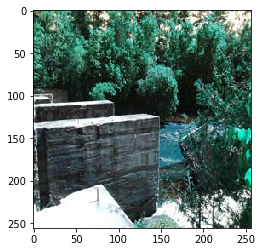

In [432]:
print_original(X_test[0], Y_test[0])

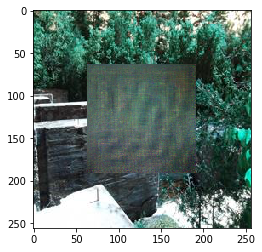

In [433]:
print_result(X_test[0])

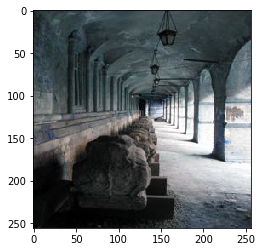

In [434]:
print_original(X_test[1], Y_test[1])

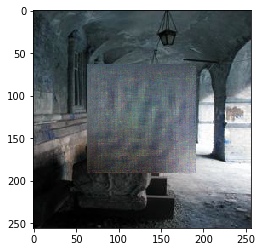

In [435]:
print_result(X_test[1])

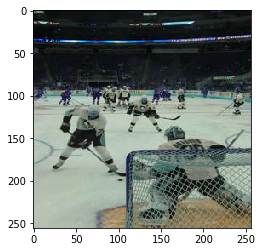

In [436]:
print_original(X_test[2], Y_test[2])

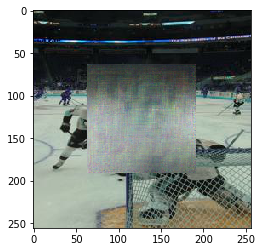

In [437]:
print_result(X_test[2])

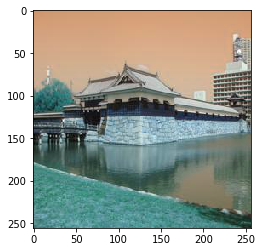

In [438]:
print_original(X_test[3], Y_test[3])

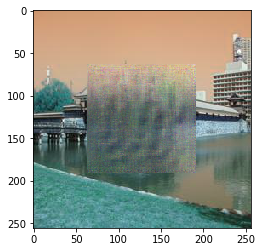

In [439]:
print_result(X_test[3])

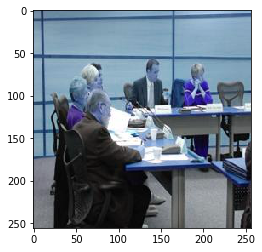

In [440]:
print_original(X_test[4], Y_test[4])

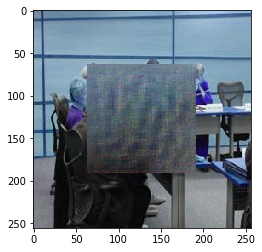

In [441]:
print_result(X_test[4])

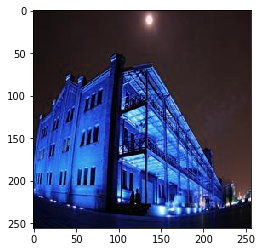

In [442]:
print_original(X_test[5], Y_test[5])

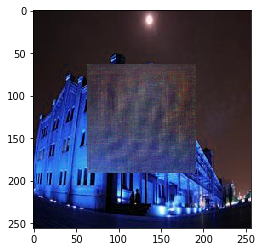

In [443]:
print_result(X_test[5])